# 3D-BPP

## Pre-requisites

In [1]:
import os
from collections import namedtuple
from time import time

import numpy as np
import pandas as pd
import seaborn as sns
from ortools.sat.python import cp_model
from matplotlib import pyplot as plt
from tqdm import tqdm

from src import config, dataset, main, utils, bins

In [2]:
%matplotlib notebook
%load_ext autoreload
%load_ext nb_black
%autoreload 2

<IPython.core.display.Javascript object>

In [3]:
plt.style.use("seaborn")
np.random.seed(config.RANDOM_SEED)

<IPython.core.display.Javascript object>

## Pallets and containers

Pallet EUR:

|       |  $L\times W\times H (cm)$   | Load (kg)  |
|:-----:|:--------------------------:|:--------:|
| EUR 1 |  $80\times 120\times 14.5$ |  $2490$  |
| EUR 2 | $120\times 100\times 14.4$ |  $1470$  |
| EUR 3 | $100\times 120\times 14.4$ |  $1920$  |
| EUR 6 |  $80\times 60\times 14.4$  |   $500$  |

Container ISO:

|   |  $L\times W\times H (cm)$  | Load (kg) |
|:-:|:--------------------------:|:--------:|
| 1A | $233\times 1200\times 220$ |  $26480$ |
| 1C |  $233\times 587\times 220$ |  $28180$ |

## Dataset

### Products

In [4]:
product_dataset = dataset.ProductDataset(
    "data/products.pkl",
    config.NUM_PRODUCTS,
    config.MIN_PRODUCT_WIDTH,
    config.MAX_PRODUCT_WIDTH,
    config.MIN_PRODUCT_DEPTH,
    config.MAX_PRODUCT_DEPTH,
    config.MIN_PRODUCT_HEIGHT,
    config.MAX_PRODUCT_HEIGHT,
    config.MIN_PRODUCT_WEIGHT,
    config.MAX_PRODUCT_WEIGHT,
    force_overload=False,
)
product_dataset.products.head()

,width,depth,height,weight,volume
0,160,280,233,8,10438400
1,199,269,260,11,13918060
2,187,101,283,2,5345021
3,126,149,214,2,4017636
4,248,132,280,3,9166080


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


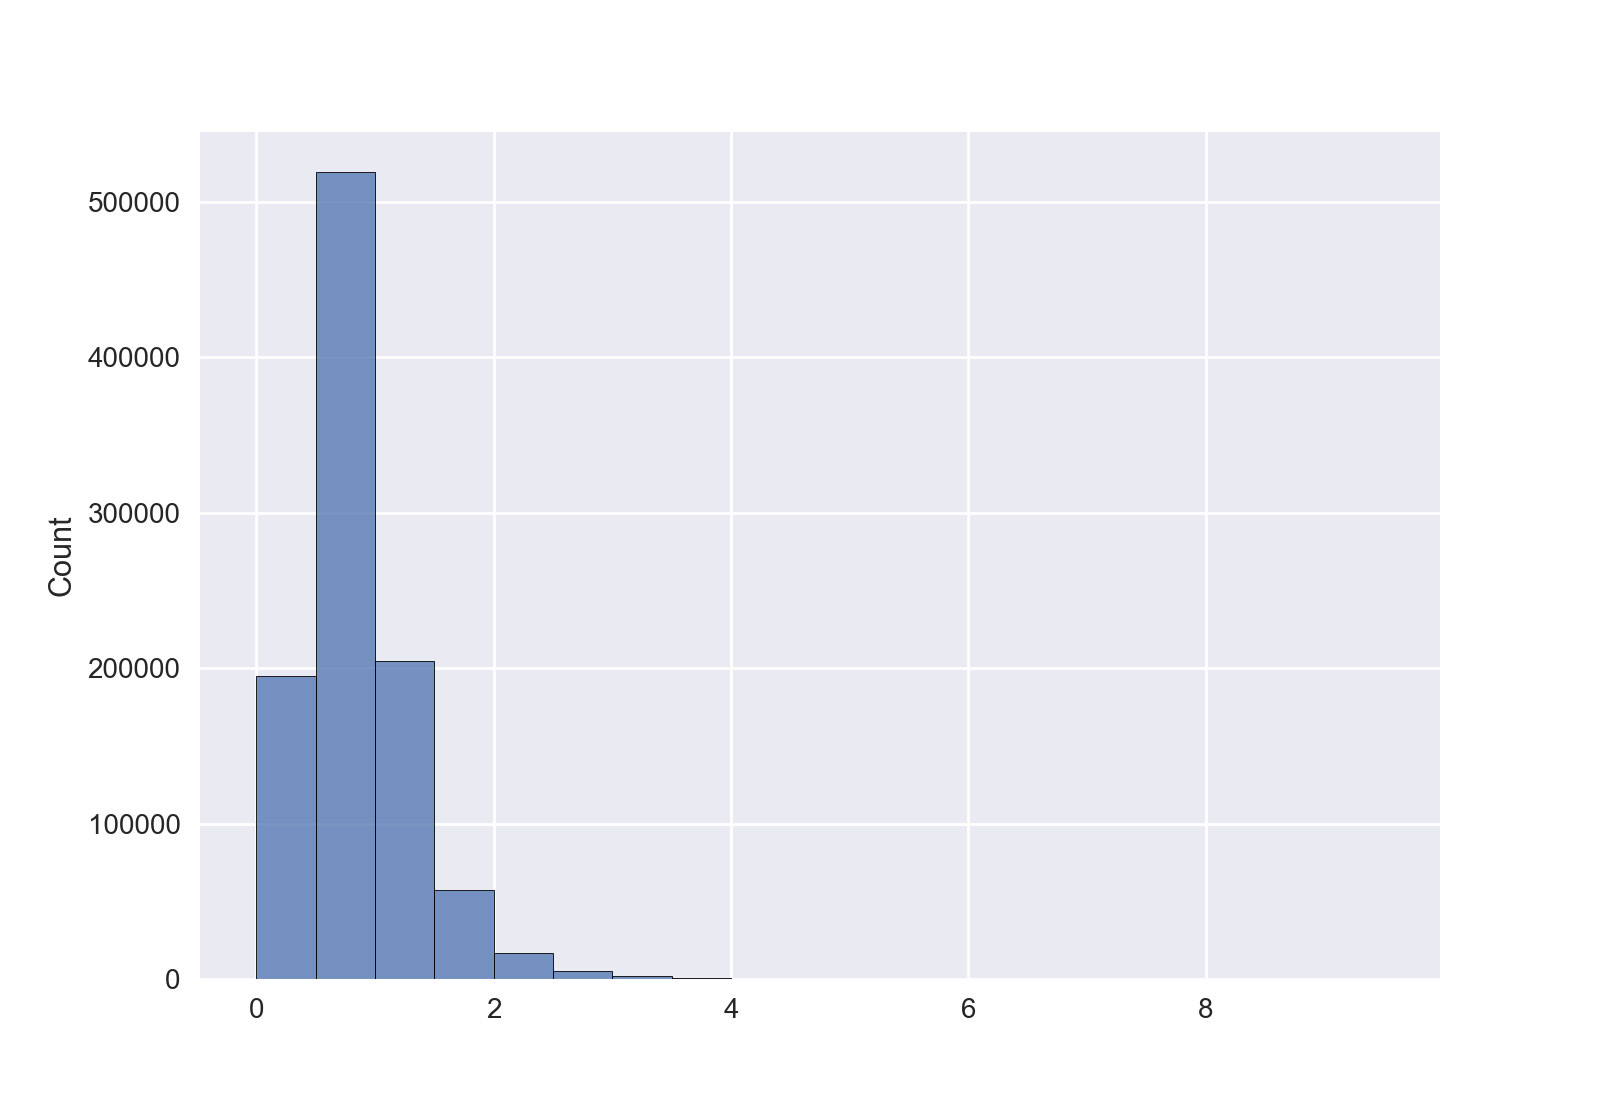

<IPython.core.display.Javascript object>

In [59]:
plt.figure()
sns.histplot(
    product_dataset.products.depth / product_dataset.products.width,
    bins=np.arange(0, 10, 0.5),
)
plt.show()

<IPython.core.display.Javascript object>


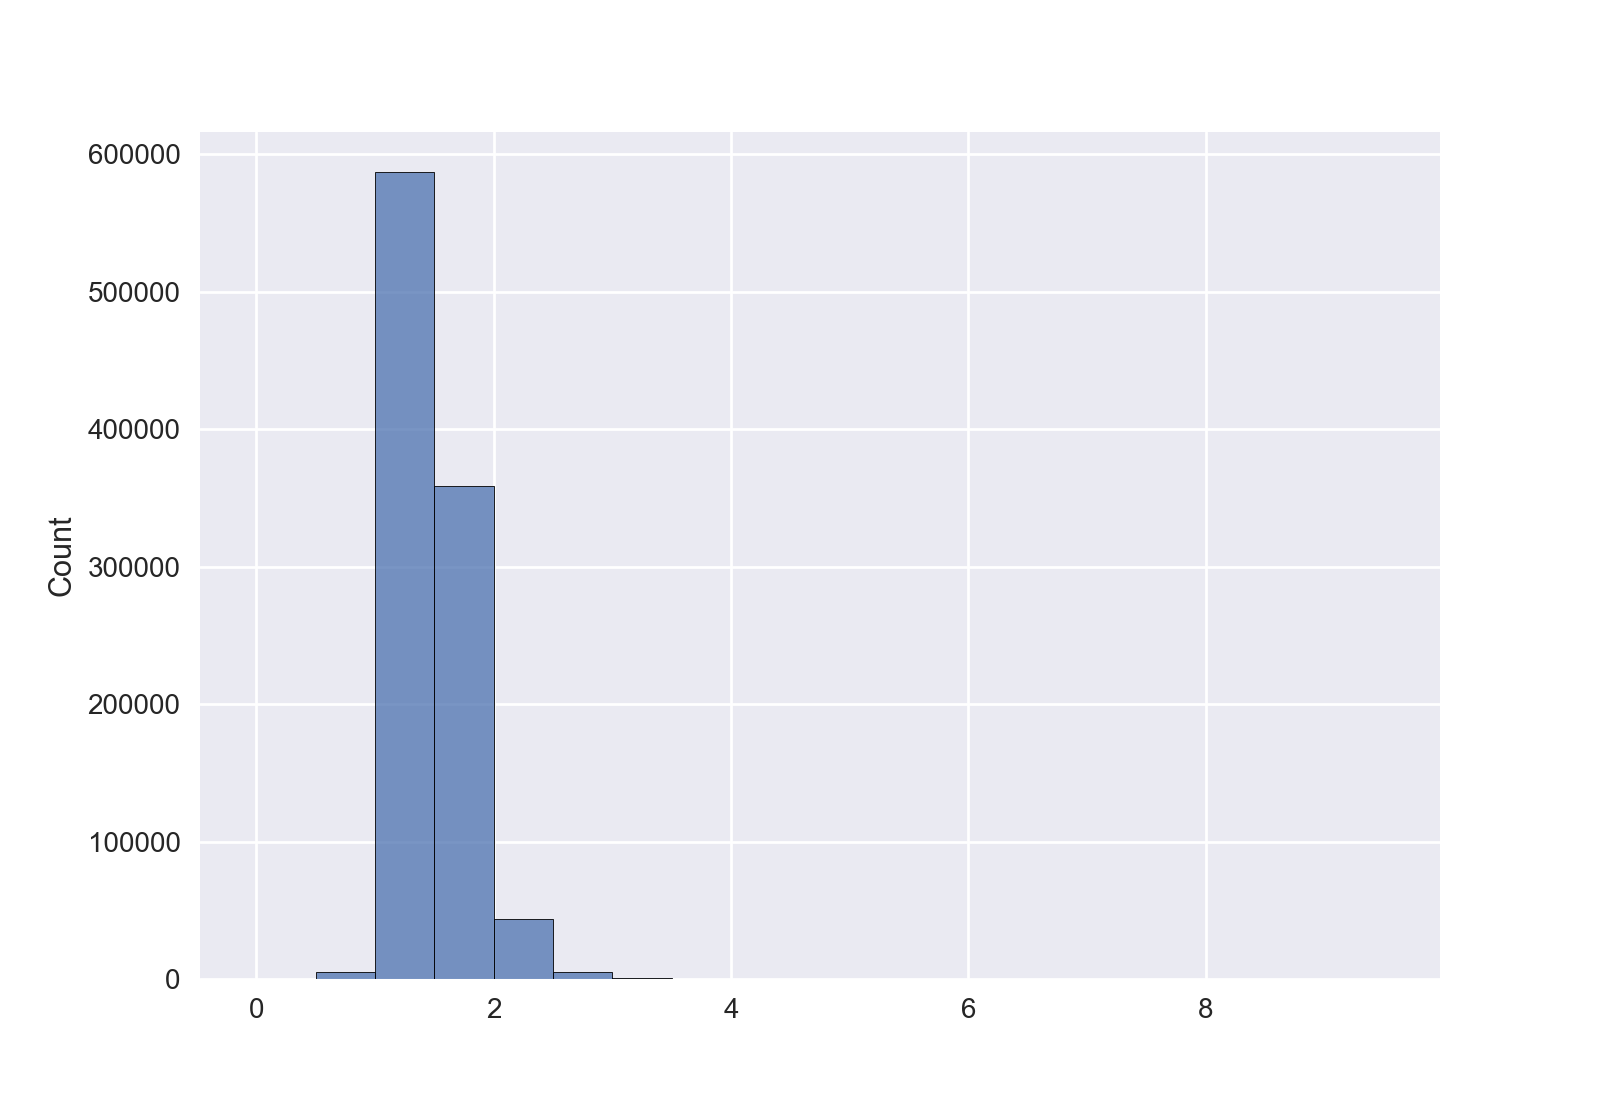

<IPython.core.display.Javascript object>

In [60]:
plt.figure()
sns.histplot(
    product_dataset.products.height / product_dataset.products.width,
    bins=np.arange(0, 10, 0.5),
)
plt.show()

<IPython.core.display.Javascript object>


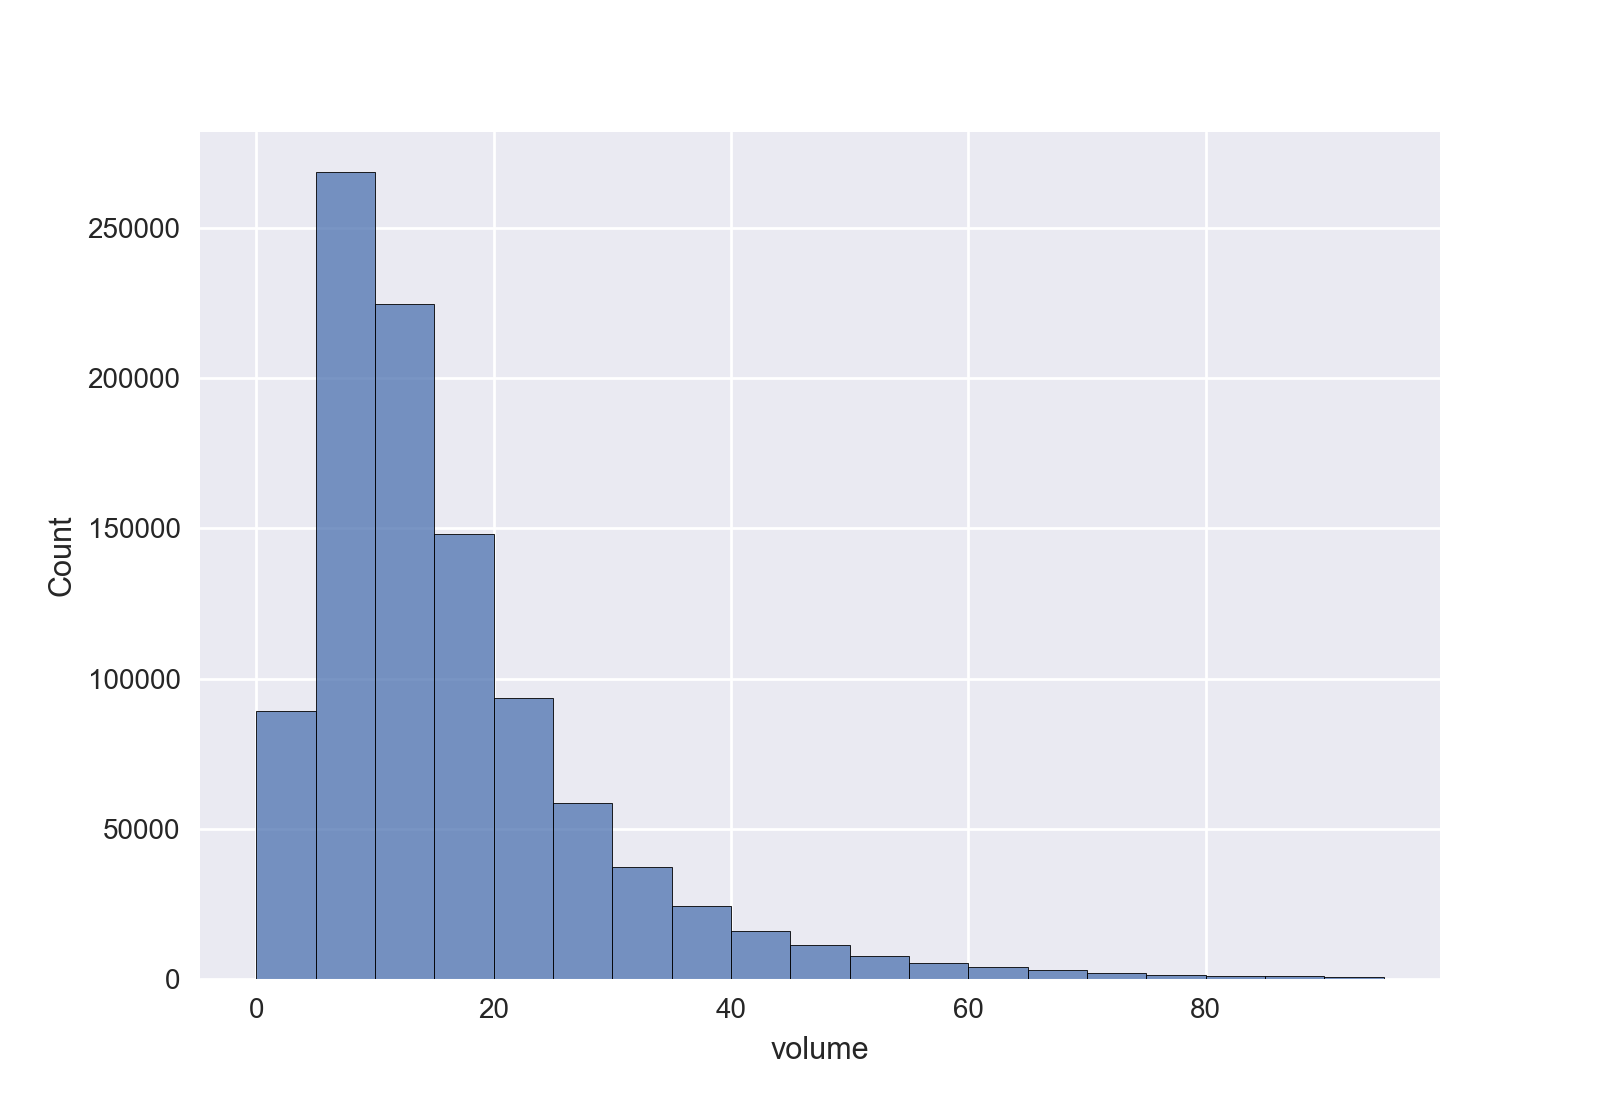

<IPython.core.display.Javascript object>

In [61]:
plt.figure()
sns.histplot(product_dataset.products.volume / 1e6, bins=np.arange(0, 100, 5))
plt.show()

<IPython.core.display.Javascript object>


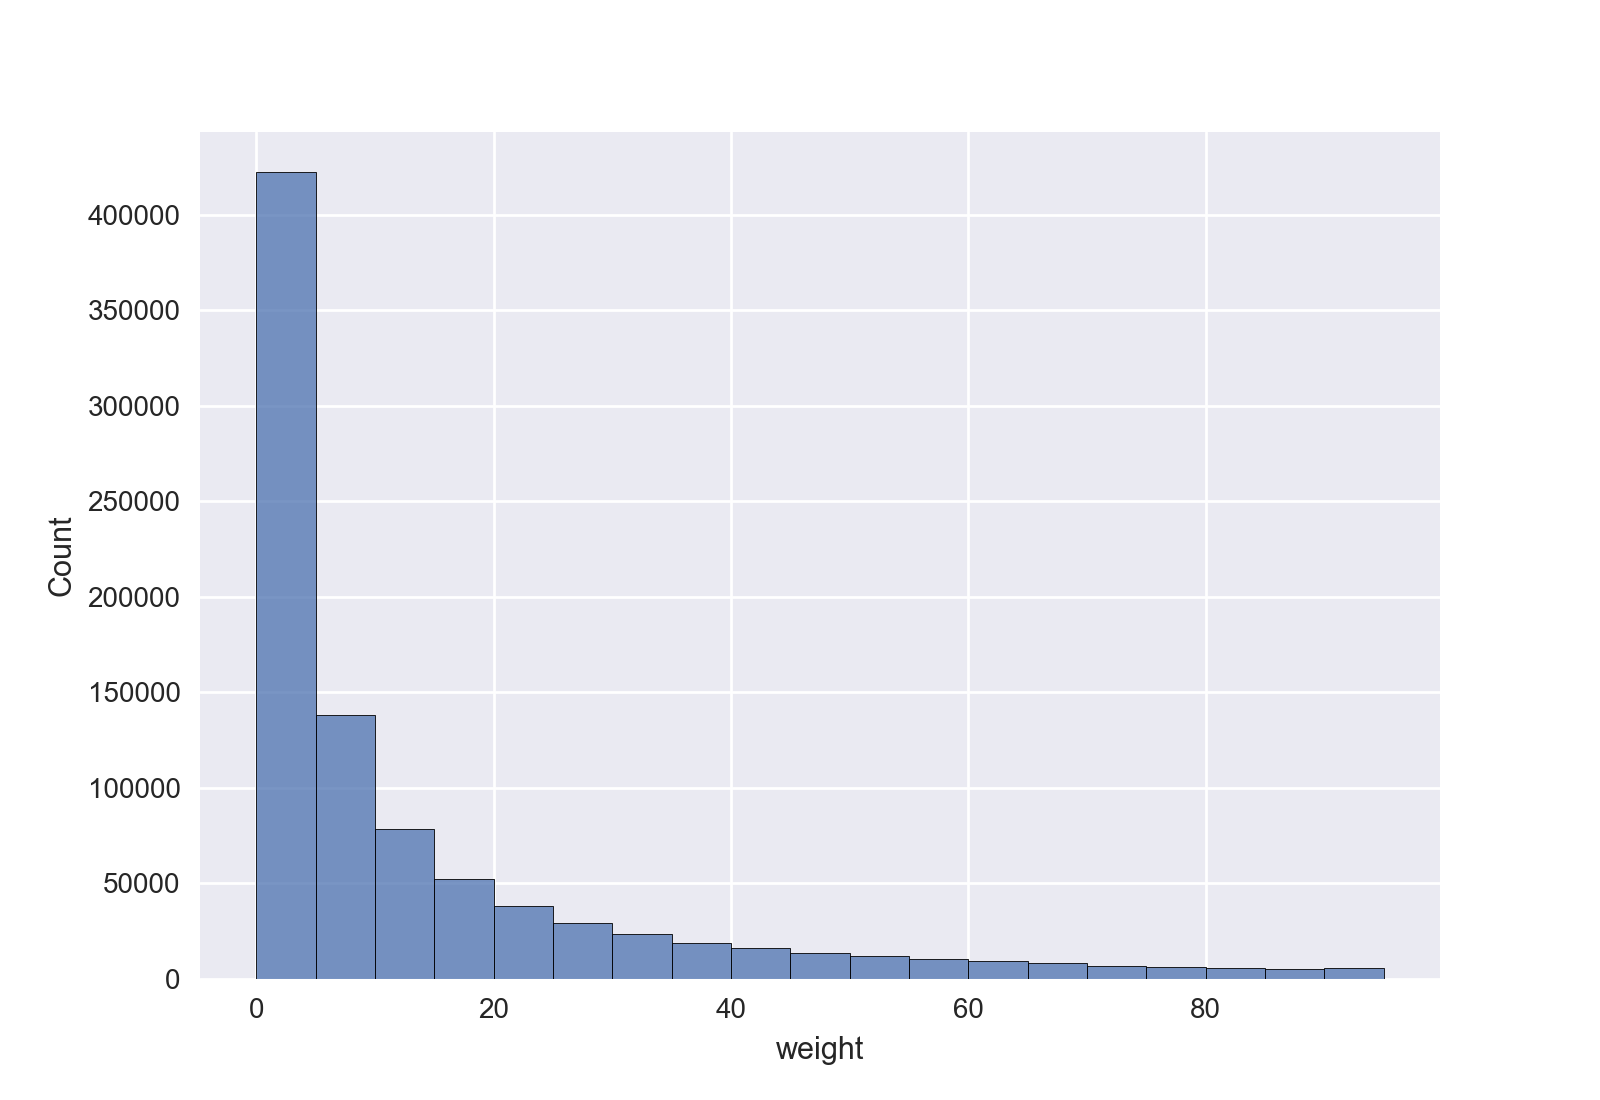

<IPython.core.display.Javascript object>

In [62]:
plt.figure()
sns.histplot(product_dataset.products.weight, bins=np.arange(0, 100, 5))
plt.show()

### Order

In [104]:
ordered_products = 20
order = product_dataset.get_order(ordered_products)
# order = product_dataset.get_dummy_order(ordered_products)
order.head()

,id,width,depth,height,weight,volume
0,927460,345,191,446,2,29389170
1,497660,190,181,285,35,9801150
2,76373,130,409,392,2,20842640
3,855684,371,319,595,9,70417655
4,193021,210,182,324,4,12383280


<IPython.core.display.Javascript object>

## Martello's lower bounds

In [8]:
utils.get_l0_lb(order, config.PALLET_DIMS)

1.0

<IPython.core.display.Javascript object>

In [9]:
utils.get_l1_lb(order, config.PALLET_DIMS)

(0.0, 0.0, 0.0, 0.0)

<IPython.core.display.Javascript object>

In [10]:
utils.get_l2_lb(order, config.PALLET_DIMS)

100it [00:00, 204.90it/s]
100it [00:00, 228.45it/s]
100it [00:00, 228.52it/s]


(1.0, 1.0, 1.0, 1.0)

<IPython.core.display.Javascript object>

## Baseline

In [11]:
bl_layer_pool = main.baseline_procedure(order)
bl_layer_pool.to_dataframe()

Generating vertical superitems: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Items not covered: 0/10


,item,x,y,z,width,depth,height,layer
0,0,353,0,0,343,263,411,0
1,1,0,0,0,294,136,440,0
2,2,0,136,0,180,57,234,0
3,3,0,193,0,176,100,225,0
4,4,180,136,0,173,179,248,0
5,5,0,315,0,202,210,349,0
6,6,0,525,0,366,256,654,0
7,7,366,263,0,277,192,416,0
8,8,643,263,0,286,162,450,0
9,9,929,0,0,249,237,318,0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


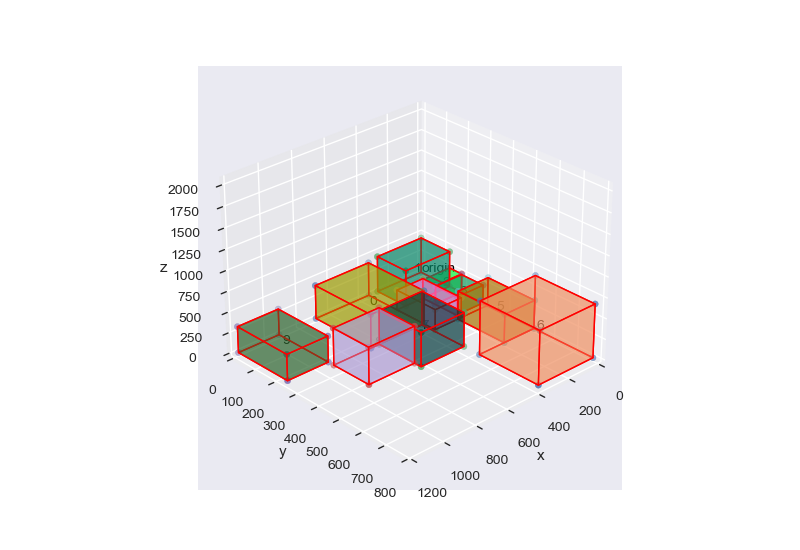

<IPython.core.display.Javascript object>

In [12]:
bl_bin_pool = bins.BinPool(bl_layer_pool, config.PALLET_DIMS)
bl_bin_pool.plot()

## Maxrects

In [105]:
mr_layer_pool = main.maxrect_procedure(order)
mr_layer_pool.to_dataframe()

Generating vertical superitems: 100%|████████████████████████████████████████████████████████████| 5/5 [00:00<?, ?it/s]


ValueError: No objects to concatenate

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


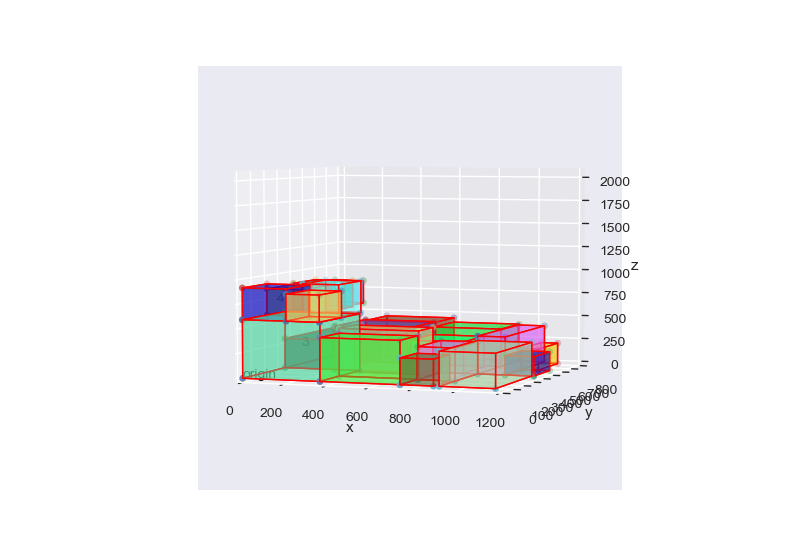

<IPython.core.display.Javascript object>

In [114]:
mr_bin_pool = bins.BinPool(mr_layer_pool, config.PALLET_DIMS)
mr_bin_pool.plot()

## Column generation

In [141]:
filtered_cg_layer_pool, cg_layer_pool, cg_bins_lbs = main.column_generation_procedure(
    order, use_height_groups=False
)
cg_layer_pool.to_dataframe()

Generating vertical superitems: 100%|████████████████████████████████████████████████████████████| 5/5 [00:00<?, ?it/s]


Height group 1/1
Iteration 1/100
Solving RMP...
RMP objective: 2074.5
Duals: [  0.  278.  392.  459.5   0.    0.    0.    0.    0.    0.  346.    0.
   0.  266.  333.    0.    0.    0.    0.    0. ]
RMP time: 0.498
Alpha: [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 1.0, 0.0]
RMP: solution not feasible (at least one alpha value is not binary)
Solving SP (no placement)...
SP no placement time: 4.8858e-06
[1, 2, 3, 10, 13, 14]
Reduced cost: -1481.0


,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,10,0,319,0,255,350,346
2,2,255,319,0,130,409,392
3,14,371,0,0,175,209,333
4,1,385,209,0,190,181,285
5,13,546,0,0,154,142,266


Iteration 2/100
Solving RMP...
RMP objective: 1684.6666666666667
Duals: [  0.           0.         392.         105.66666667 322.66666667
 457.           0.           0.           0.           0.
   0.           0.           0.          97.33333333   0.
   0.           0.           0.         310.           0.        ]
RMP time: 0.576
Alpha: [0.0, 0.0, 0.6666666666666666, 0.0, 0.0, 5.551115123125783e-17, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.33333333333333337, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3333333333333333, 0.6666666666666666, 0.0, 0.3333333333333335]
RMP: solution not feasible (at least one alpha value is not binary)
Solving SP (no placement)...
SP no placement time: 1.5747357e-05
[2, 4, 5, 13, 18]
Reduced cost: -1123.0


,item,x,y,z,width,depth,height
0,18,0,0,0,250,399,310
1,5,0,399,0,352,259,457
2,13,0,658,0,154,142,266
3,4,250,0,0,210,182,324
4,2,352,182,0,130,409,392


Iteration 3/100
Solving RMP...
RMP objective: 1367.25
Duals: [  0.     0.   147.   448.     0.     0.     0.     0.   168.75  47.5
   0.     0.     0.     0.     0.     0.   246.     0.   310.     0.  ]
RMP time: 0.521
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.25, 0.5, 0.0, 0.5, 0.5]
RMP: solution not feasible (at least one alpha value is not binary)
Solving SP (no placement)...
SP no placement time: 1.3478768e-05
[2, 3, 8, 9, 18, 27]
Reduced cost: -774.0


,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,18,0,319,0,250,399,310
2,2,250,319,0,130,409,392
3,9,371,0,0,378,126,489
4,16,375,131,0,149,165,246
5,11,371,126,246,158,175,272
6,8,749,0,0,81,208,220


Iteration 4/100
Solving RMP...
RMP objective: 1367.25
Duals: [  0.    34.   147.    81.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.   333.     0.    57.   207.25 310.   198.  ]
RMP time: 0.526
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.850462293418877e-17, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.25, 0.5, 0.0, 0.5, 0.49999999999999994, 0.0]
RMP: solution not feasible (at least one alpha value is not binary)
Solving SP (no placement)...
SP no placement time: 6.669726000000001e-06
[1, 2, 14, 16, 17, 18, 19]
Reduced cost: -849.0


,item,x,y,z,width,depth,height
0,18,0,0,0,250,399,310
1,17,0,399,0,374,151,440
2,14,0,550,0,175,209,333
3,1,175,550,0,190,181,285
4,16,365,550,0,149,165,246
5,19,250,0,0,135,165,198
6,2,385,0,0,130,409,392


Iteration 5/100
Solving RMP...
RMP objective: 1318.0
Duals: [  0.    0.  249.    0.  197.    0.    0.    0.  220.  115.  346.    0.
   0.    0.    0.    0.    0.  117.5  11.   62.5]
RMP time: 0.583
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.11111111111111124, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2222222222222222, 0.4444444444444444, 0.0, 0.4444444444444443, 0.3333333333333334, 0.1111111111111111, 0.11111111111111113]
RMP: solution not feasible (at least one alpha value is not binary)
Solving SP (no placement)...
SP no placement time: 1.2314058000000001e-05
[2, 4, 9, 10, 17, 18, 26]
Reduced cost: -833.0


,item,x,y,z,width,depth,height
0,18,0,0,0,250,399,310
1,10,0,399,0,255,350,346
2,17,250,0,0,374,151,440
3,9,250,151,0,378,126,489
4,2,628,0,0,130,409,392
5,4,255,277,0,210,182,324
6,8,492,277,0,81,208,220
7,19,465,298,220,135,165,198


Iteration 6/100
Solving RMP...
RMP objective: 1290.6428571428573
Duals: [  0.          93.28571429   0.         205.78571429   0.
 306.42857143   0.           0.          42.5          0.
 295.92857143   0.           0.           0.           0.
   0.         196.14285714   0.         150.57142857   0.        ]
RMP time: 0.559
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2142857142857144, 0.42857142857142866, 0.0, 0.49999999999999994, 0.35714285714285704, 0.07142857142857141, 0.07142857142857145, 0.07142857142857138]
RMP: solution not feasible (at least one alpha value is not binary)
Solving SP (no placement)...
SP no placement time: 1.6334522e-05
[1, 3, 5, 10, 18, 26, 27]
Reduced cost: -699.0


,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,18,0,319,0,250,399,310
2,5,250,319,0,352,259,457
3,1,250,578,0,190,181,285
4,8,467,578,0,81,208,220
5,19,440,599,220,135,165,198
6,16,579,583,0,149,165,246
7,11,575,578,246,158,175,272
8,10,602,0,0,255,350,346


Iteration 7/100
Solving RMP...
RMP objective: 1283.8372093023256
Duals: [  0.           0.          95.27906977 194.74418605   0.
 333.65116279   0.           0.           0.         276.90697674
  38.53488372   0.           0.           0.         266.44186047
   0.           0.          50.20930233  28.06976744   0.        ]
RMP time: 0.573
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.20930232558139536, 0.441860465116279, 0.0, 0.4651162790697675, 0.3023255813953489, 0.06976744186046514, 0.09302325581395349, 0.06976744186046512, 0.046511627906976744]
RMP: solution not feasible (at least one alpha value is not binary)
Solving SP (no placement)...
SP no placement time: 1.8937855e-05
[2, 3, 5, 9, 10, 14, 17, 18]
Reduced cost: -693.0


,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,18,0,319,0,250,399,310
2,5,250,319,0,352,259,457
3,17,250,578,0,374,151,440
4,9,371,0,0,378,126,489
5,10,602,126,0,255,350,346
6,14,624,476,0,175,209,333
7,2,857,0,0,130,409,392


Iteration 8/100
Solving RMP...
RMP objective: 1252.6451612903227
Duals: [  0.         105.5483871   73.5483871  322.22580645 309.90322581
   0.           0.           0.           0.          32.
   0.           0.           0.           0.          93.67741935
 148.51612903  93.67741935   0.          73.5483871    0.        ]
RMP time: 0.637
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.19354838709677416, 0.41935483870967744, 0.0, 0.4516129032258061, 0.2903225806451616, 0.032258064516129094, 0.06451612903225809, 0.09677419354838676, 0.06451612903225816, 0.0645161290322584]
RMP: solution not feasible (at least one alpha value is not binary)
Solving SP (no placement)...
SP no placement time: 1.0004447e-05
[1, 2, 3, 4, 9, 14, 15, 18, 27]
Reduced cost: -661.0


,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,18,0,319,0,250,399,310
2,2,250,319,0,130,409,392
3,15,371,0,0,255,198,326
4,9,626,0,0,378,126,489
5,14,1004,0,0,175,209,333
6,4,626,126,0,210,182,324
7,16,840,131,0,149,165,246
8,11,836,126,246,158,175,272
9,1,994,209,0,190,181,285


Iteration 9/100
Solving RMP...
RMP objective: 1212.7191011235955
Duals: [ 63.42696629 179.25842697  49.07865169 219.88764045 146.7752809
 114.37078652   0.           0.          81.48314607   0.
   0.           0.           0.         146.7752809    0.
   0.           0.         211.66292135   0.           0.        ]
RMP time: 0.666
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.16853932584269665, 0.4157303370786517, 0.0, 0.37078651685393277, 0.21348314606741564, 0.0, 0.06741573033707851, 0.11235955056179775, 0.05617977528089888, 0.14606741573033716, 0.08988764044943813]
RMP: solution not feasible (at least one alpha value is not binary)
Solving SP (no placement)...
SP no placement time: 1.7832147e-05
[0, 1, 2, 3, 4, 5, 13, 17, 26]
Reduced cost: -622.0


,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,5,0,319,0,352,259,457
2,0,0,578,0,345,191,446
3,17,345,578,0,374,151,440
4,4,352,319,0,210,182,324
5,1,371,0,0,190,181,285
6,8,588,0,0,81,208,220
7,19,561,21,220,135,165,198
8,13,562,208,0,154,142,266
9,2,716,0,0,130,409,392


Iteration 10/100
Solving RMP...
RMP objective: 1205.2377049180327
Duals: [  0.         117.92622951  48.40983607 154.70491803  48.70491803
   0.         266.76229508   0.           0.           0.
 118.22131148   0.           0.         155.73770492   0.
  21.10655738   0.          69.51639344 204.14754098   0.        ]
RMP time: 0.667
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.16393442622950805, 0.418032786885246, 0.0, 0.36065573770491827, 0.20491803278688508, 0.0, 0.0655737704918035, 0.10655737704918038, 0.049180327868851785, 0.1557377049180334, 0.09016393442622973, 0.016393442622950654]
RMP: solution not feasible (at least one alpha value is not binary)
Solving SP (no placement)...
SP no placement time: 6.124139e-06
[1, 2, 3, 4, 6, 10, 13, 15, 17, 18]
Reduced cost: -615.0


,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,18,0,319,0,250,399,310
2,10,250,319,0,255,350,346
3,6,371,0,0,330,191,399
4,17,701,0,0,374,151,440
5,2,701,151,0,130,409,392
6,1,505,191,0,190,181,285
7,13,505,372,0,154,142,266
8,15,505,560,0,255,198,326
9,4,760,560,0,210,182,324


Iteration 11/100
Solving RMP...
RMP objective: 1033.5
Duals: [220.47368421  20.26315789  38.65789474  66.92105263   0.
 108.34210526   0.           0.          89.47368421   0.
   0.           0.           0.           0.          20.21052632
 108.28947368   0.          50.86842105 310.           0.        ]
RMP time: 0.672
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.005191976875696e-16, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4999999999999999, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0289252287715981e-17, 0.5000000000000001, 0.0, 1.5700924586837752e-16, 0.5]
RMP: solution not feasible (at least one alpha value is not binary)
Solving SP (no placement)...
SP no placement time: 9.013499000000002e-06
[0, 1, 2, 5, 8, 14, 15, 17, 18]
Reduced cost: -514.0


,item,x,y,z,width,depth,height
0,18,0,0,0,250,399,310
1,5,0,399,0,352,259,457
2,0,250,0,0,345,191,446
3,17,250,191,0,374,151,440
4,1,595,0,0,190,181,285
5,2,785,0,0,130,409,392
6,8,624,181,0,81,208,220
7,15,352,342,0,255,198,326
8,14,607,389,0,175,209,333


Iteration 12/100
Solving RMP...
RMP objective: 1033.5000000000005
Duals: [  0.           0.           0.         175.72058824   0.
  79.42647059   0.           0.           0.          95.42647059
  19.22058824   0.           0.          71.33823529  48.85294118
 152.36764706  16.79411765  70.51470588 105.83823529 198.        ]
RMP time: 0.706
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.974524306077727e-18, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 2.6405702402481546e-16, 1.2595086097350223e-16, 0.4999999999999999, 1.8566509501744838e-16, 0.0, 0.5000000000000001, 2.220446049250313e-16]
RMP: solution not feasible (at least one alpha value is not binary)
Solving SP (no placement)...
SP no placement time: 7.0315e-06
[3, 5, 9, 10, 13, 14, 15, 17, 18, 26, 27]
Reduced cost: -443.0


,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,18,0,319,0,250,399,310
2,5,250,319,0,352,259,457
3,17,250,578,0,374,151,440
4,15,371,0,0,255,198,326
5,10,602,198,0,255,350,346
6,9,626,0,0,378,126,489
7,14,624,548,0,175,209,333
8,8,826,548,0,81,208,220
9,19,799,569,220,135,165,198


Iteration 13/100
Solving RMP...
RMP objective: 1033.5000000000002
Duals: [204.75   0.   230.75 132.75   3.     0.     0.     0.    21.5    3.
 228.5    0.     0.     0.     0.     0.   207.     0.     0.     2.25]
RMP time: 0.706
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 4.95106920046529e-17, 1.5700924586837752e-16, 4.9510692004652915e-17, 0.0, 0.5000000000000002, 0.0, 8.715763992105247e-33, 0.5, 0.0, 0.0]
RMP: solution not feasible (at least one alpha value is not binary)
Solving SP (no placement)...
SP no placement time: 1.4103201e-05
[0, 2, 4, 10, 16, 26]
Reduced cost: -454.0


,item,x,y,z,width,depth,height
0,10,0,0,0,255,350,346
1,0,0,350,0,345,191,446
2,4,0,541,0,210,182,324
3,8,237,541,0,81,208,220
4,19,210,562,220,135,165,198
5,16,255,0,0,149,165,246
6,2,345,165,0,130,409,392


Iteration 14/100
Solving RMP...
RMP objective: 1033.5
Duals: [206.25       221.08333333  11.16666667 141.66666667   0.
   0.           0.           0.          11.16666667 217.41666667
 217.41666667   0.           0.           0.           3.66666667
   0.           0.           3.66666667   0.           0.        ]
RMP time: 0.731
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4999999999999999, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5000000000000001, 0.0, 0.0, 0.4999999999999999, 8.801900800827182e-17, 0.0, 6.899023786010569e-17]
RMP: solution not feasible (at least one alpha value is not binary)
Solving SP (no placement)...
SP no placement time: 1.0723594e-05
[0, 1, 2, 3, 8, 9, 10, 14, 17]
Reduced cost: -444.0


,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,10,0,319,0,255,350,346
2,9,0,669,0,378,126,489
3,0,255,319,0,345,191,446
4,17,255,510,0,374,151,440
5,14,371,0,0,175,209,333
6,1,546,0,0,190,181,285
7,8,600,181,0,81,208,220
8,2,629,389,0,130,409,392


Iteration 15/100
Solving RMP...
RMP objective: 1017.2222222222222
Duals: [ 44.44444444 122.22222222   0.          38.66666667 223.
 166.66666667  32.55555556   0.           0.          87.44444444
 178.55555556   0.           0.           0.         123.66666667
   0.           0.           0.           0.           0.        ]
RMP time: 0.744
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.33333333333333337, 0.0, 0.0, 0.0, 0.0, 0.0, 0.11111111111111124, 0.0, 0.16666666666666674, 0.05555555555555552, 0.11111111111111115, 0.33333333333333326, 0.11111111111111113, 0.27777777777777757, 0.05555555555555547, 0.055555555555555594]
RMP: solution not feasible (at least one alpha value is not binary)
Solving SP (no placement)...
SP no placement time: 6.541625e-06
[0, 1, 4, 5, 6, 9, 10, 14]
Reduced cost: -493.0


,item,x,y,z,width,depth,height
0,5,0,0,0,352,259,457
1,10,0,259,0,255,350,346
2,0,0,609,0,345,191,446
3,6,255,259,0,330,191,399
4,9,255,450,0,378,126,489
5,4,345,576,0,210,182,324
6,14,555,576,0,175,209,333
7,1,352,0,0,190,181,285


Iteration 16/100
Solving RMP...
RMP objective: 1004.5277777777777
Duals: [ 55.16666667  82.25       182.16666667  46.91666667  32.
  91.08333333   0.          57.94444444   0.         128.58333333
  99.91666667   0.           0.         105.41666667   0.
   0.          76.75         0.          46.33333333   0.        ]
RMP time: 0.745
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3333333333333333, 0.0, 0.0, 4.996003610813204e-16, 0.0, 0.0, 0.0833333333333327, 0.0, 0.2222222222222223, 0.05555555555555564, 0.11111111111111074, 0.3333333333333334, 0.08333333333333304, 0.2222222222222221, 0.05555555555555562, 0.05555555555555584, 0.027777777777778102]
RMP: solution not feasible (at least one alpha value is not binary)
Solving SP (no placement)...
SP no placement time: 1.1438984000000001e-05
[0, 1, 2, 4, 5, 7, 9, 10, 13, 16, 18]
Reduced cost: -474.0


,item,x,y,z,width,depth,height
0,18,0,0,0,250,399,310
1,5,0,399,0,352,259,457
2,9,0,658,0,378,126,489
3,10,250,0,0,255,350,346
4,0,352,350,0,345,191,446
5,4,378,541,0,210,182,324
6,7,588,541,0,175,204,272
7,1,505,0,0,190,181,285
8,16,505,181,0,149,165,246
9,13,654,181,0,154,142,266


Iteration 17/100
Solving RMP...
RMP objective: 990.3103448275863
Duals: [ 52.68965517   0.         103.5862069  112.06896552 152.65517241
  15.51724138   0.           0.           0.           0.
  82.24137931   0.          86.37931034  45.13793103 185.89655172
   3.62068966   0.          58.51724138  37.17241379  54.82758621]
RMP time: 0.791
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3333333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.022988505747126884, 0.0, 0.2528735632183906, 0.08045977011494272, 0.08045977011494257, 0.3448275862068962, 0.057471264367815994, 0.1839080459770117, 0.04597701149425248, 0.05747126436781633, 0.03448275862068961, 0.057471264367816265]
RMP: solution not feasible (at least one alpha value is not binary)
Solving SP (no placement)...
SP no placement time: 1.926094e-05
[0, 2, 4, 5, 10, 12, 13, 14, 15, 17, 18, 26]
Reduced cost: -427.0


,item,x,y,z,width,depth,height
0,18,0,0,0,250,399,310
1,5,0,399,0,352,259,457
2,13,0,658,0,154,142,266
3,10,250,0,0,255,350,346
4,0,352,350,0,345,191,446
5,17,352,541,0,374,151,440
6,15,505,0,0,255,198,326
7,4,697,198,0,210,182,324
8,12,760,0,0,175,183,333
9,2,907,183,0,130,409,392


Iteration 18/100
Solving RMP...
RMP objective: 966.1666666666669
Duals: [ 55.125        0.         118.66666667 177.125       62.70833333
  55.125      134.66666667   0.           0.         181.375
   0.           0.           0.           0.           0.
  39.125       16.          62.70833333   0.          63.54166667]
RMP time: 0.802
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.33333333333333326, 0.0, 0.0, 0.0, 0.0, 0.0, 1.4719616800160392e-16, 0.0, 0.2499999999999997, 0.08333333333333305, 0.08333333333333337, 0.33333333333333365, 0.0, 0.16666666666666696, 0.0, 0.08333333333333355, 0.0, 0.08333333333333359, 0.08333333333333312]
RMP: solution not feasible (at least one alpha value is not binary)
Solving SP (no placement)...
SP no placement time: 2.0260374000000002e-05
[0, 2, 3, 4, 5, 6, 9, 15, 17, 19, 27]
Reduced cost: -377.0


,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,5,0,319,0,352,259,457
2,0,0,578,0,345,191,446
3,6,345,578,0,330,191,399
4,17,352,319,0,374,151,440
5,15,675,470,0,255,198,326
6,9,675,668,0,378,126,489
7,2,1053,0,0,130,409,392
8,4,930,409,0,210,182,324
9,19,1053,591,0,135,165,198


Iteration 19/100
Solving RMP...
RMP objective: 961.7821229050279
Duals: [ 13.5027933  125.05027933  83.04469274 202.06703911   1.74860335
  86.54189944  90.82122905  52.61452514   0.          34.22905028
  40.25698324   0.           0.           0.          96.84916201
   0.           0.           0.          52.01117318  83.04469274]
RMP time: 0.786
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.30726256983240224, 0.0, 0.0, 0.0, 0.0, 0.011173184357541983, 0.0, 0.0, 0.20670391061452514, 0.0782122905027933, 0.06703910614525137, 0.33519553072625696, 0.016759776536312852, 0.18994413407821226, 0.0, 0.08938547486033518, 0.01675977653631292, 0.07821229050279326, 0.08379888268156428, 0.033519553072625656]
RMP: solution not feasible (at least one alpha value is not binary)
Solving SP (no placement)...
SP no placement time: 1.5936861e-05
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 14, 

,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,18,0,319,0,250,399,310
2,5,250,319,0,352,259,457
3,0,250,578,0,345,191,446
4,6,595,578,0,330,191,399
5,10,925,0,0,255,350,346
6,2,925,350,0,130,409,392
7,8,1082,350,0,81,208,220
8,19,1055,371,220,135,165,198
9,9,371,0,0,378,126,489


Iteration 20/100
Solving RMP...
RMP objective: 948.7708333333334
Duals: [  0.         142.52083333   0.         187.08333333  61.4375
  61.4375       0.          19.64583333   0.         122.875
   0.           0.         130.16666667   0.           0.
   0.          19.64583333 142.52083333  61.4375       0.        ]
RMP time: 0.842
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2708333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06249999999999994, 0.02083333333333332, 0.31249999999999994, 0.0, 0.25000000000000006, 0.0, 0.14583333333333348, 0.0, 0.06250000000000001, 0.18749999999999994, 0.08333333333333334, 0.12500000000000003]
RMP: solution not feasible (at least one alpha value is not binary)
Solving SP (no placement)...
SP no placement time: 9.418991e-06
[1, 3, 4, 5, 7, 9, 12, 17, 18, 27]
Reduced cost: -359.0


,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,18,0,319,0,250,399,310
2,5,250,319,0,352,259,457
3,17,250,578,0,374,151,440
4,9,371,0,0,378,126,489
5,4,371,126,0,210,182,324
6,1,581,126,0,190,181,285
7,7,602,307,0,175,204,272
8,12,771,0,0,175,183,333
9,16,628,516,0,149,165,246


Iteration 21/100
Solving RMP...
RMP objective: 933.0188679245284
Duals: [  0.          50.02830189 137.05660377 188.87735849   0.
   0.          31.95283019  58.37735849   0.          56.45283019
   0.           0.          60.60377358  96.75471698  72.25471698
   0.          90.33018868  90.33018868   0.           0.        ]
RMP time: 0.821
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2264150943396225, 0.0, 0.0, 0.0, 0.0, 0.018867924528301938, 0.0, 0.0, 0.0, 0.0754716981132075, 0.0, 0.2830188679245283, 0.0, 0.20754716981132063, 0.0, 0.07547169811320738, 0.0, 0.056603773584905814, 0.2264150943396229, 0.09433962264150961, 0.16981132075471708, 0.09433962264150951]
RMP: solution not feasible (at least one alpha value is not binary)
Solving SP (no placement)...
SP no placement time: 1.5172779e-05
[1, 2, 3, 6, 7, 9, 12, 13, 14, 17, 27]
Reduced cost: -344.0


,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,6,0,319,0,330,191,399
2,17,0,510,0,374,151,440
3,9,330,319,0,378,126,489
4,14,371,0,0,175,209,333
5,7,546,0,0,175,204,272
6,2,708,204,0,130,409,392
7,1,721,0,0,190,181,285
8,12,374,445,0,175,183,333
9,16,553,450,0,149,165,246


Iteration 22/100
Solving RMP...
RMP objective: 913.6229508196723
Duals: [ 79.91803279  75.50819672   0.         231.14754098  78.86885246
   0.          24.81967213   0.           0.           0.
 129.55737705   0.          59.50819672   0.          54.04918033
  30.27868852 125.14754098  24.81967213   0.           0.        ]
RMP time: 0.875
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.18032786885245886, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.04918032786885237, 0.0, 0.24590163934426218, 0.0, 0.1967213114754098, 0.0, 0.0163934426229507, 0.0, 0.09836065573770494, 0.24590163934426246, 0.08196721311475434, 0.19672131147540997, 0.09836065573770508, 0.1147540983606558]
RMP: solution not feasible (at least one alpha value is not binary)
Solving SP (no placement)...
SP no placement time: 1.0180553e-05
[0, 1, 3, 4, 6, 10, 12, 14, 15, 17, 27]
Reduced cost: -324.0


,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,10,0,319,0,255,350,346
2,0,255,319,0,345,191,446
3,6,371,0,0,330,191,399
4,17,255,510,0,374,151,440
5,15,600,191,0,255,198,326
6,4,701,0,0,210,182,324
7,14,855,182,0,175,209,333
8,1,911,0,0,190,181,285
9,12,629,389,0,175,183,333


Iteration 23/100
Solving RMP...
RMP objective: 902.7727272727273
Duals: [  0.         101.42045455  34.97727273  95.19318182  57.125
   0.          22.14772727  57.125       45.78409091 169.88636364
  68.46590909   0.          34.97727273   0.           0.
 136.39772727   0.          79.27272727   0.           0.        ]
RMP time: 0.847
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.18181818181818188, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.045454545454545414, 0.0, 0.22727272727272677, 0.0, 0.181818181818182, 0.0, 0.045454545454545754, 0.0, 0.09090909090909123, 0.227272727272727, 0.090909090909091, 0.1818181818181816, 0.09090909090909052, 0.09090909090909088, 0.04545454545454589]
RMP: solution not feasible (at least one alpha value is not binary)
Solving SP (no placement)...
SP no placement time: 5.4900020000000004e-06
[1, 2, 4, 6, 7, 9, 10, 12, 15, 17, 26]
Redu

,item,x,y,z,width,depth,height
0,10,0,0,0,255,350,346
1,6,0,350,0,330,191,399
2,17,0,541,0,374,151,440
3,15,255,0,0,255,198,326
4,9,255,198,0,378,126,489
5,4,510,0,0,210,182,324
6,7,330,324,0,175,204,272
7,1,374,528,0,190,181,285
8,12,505,324,0,175,183,333
9,8,591,507,0,81,208,220


Iteration 24/100
Solving RMP...
RMP objective: 898.6164383561645
Duals: [ 13.23287671   0.          58.79452055 264.5890411  127.89041096
   0.           0.          78.20547945  74.63013699  36.12328767
  56.19178082   0.          25.49315068  55.8630137   13.23287671
  31.67123288  62.69863014   0.           0.           0.        ]
RMP time: 0.921
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.16095890410958907, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.04794520547945252, 0.03424657534246664, 0.18835616438356176, 0.0, 0.19863013698630105, 0.0, 0.0, 0.0, 0.0924657534246577, 0.20890410958904018, 0.07534246575342397, 0.19178082191780796, 0.07191780821917719, 0.11643835616438376, 0.07534246575342544, 0.044520547945206046]
RMP: solution not feasible (at least one alpha value is not binary)
Solving SP (no placement)...
SP no placement time: 1.1138415000000001e-05
[0, 

,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,10,0,319,0,255,350,346
2,9,0,669,0,378,126,489
3,0,255,319,0,345,191,446
4,13,255,510,0,154,142,266
5,15,409,510,0,255,198,326
6,4,371,0,0,210,182,324
7,14,581,0,0,175,209,333
8,7,600,209,0,175,204,272
9,12,756,0,0,175,183,333


Iteration 25/100
Solving RMP...
RMP objective: 894.6056242969631
Duals: [ 25.69898763  83.17075366  66.11248594 142.99370079  63.8704162
   2.41889764  60.75298088   0.         118.72125984  13.90776153
   0.           0.           0.          17.89538808   0.67334083
   8.34623172 136.78042745  72.71316085  79.14488189   1.40494938]
RMP time: 0.9
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1588301462317211, 0.0, 0.0, 0.0, 0.0, 0.006074240719910392, 0.0, 0.0, 0.0, 0.014623172103486789, 0.003374578177727636, 0.2085489313835772, 0.015973003374578205, 0.1732283464566925, 0.0, 0.0, 0.0, 0.07964004499437535, 0.20427446569178867, 0.06704161979752543, 0.19145106861642297, 0.10618672665916806, 0.11496062992126, 0.06344206974128198, 0.036895388076490315, 0.057142857142857634]
RMP: solution not feasible (at least one alpha value is not binary)
Solving SP (no placement)...

,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,18,0,319,0,250,399,310
2,5,250,319,0,352,259,457
3,0,250,578,0,345,191,446
4,6,595,578,0,330,191,399
5,2,925,0,0,130,409,392
6,17,602,409,0,374,151,440
7,15,925,560,0,255,198,326
8,13,976,409,0,154,142,266
9,8,1082,0,0,81,208,220


Iteration 26/100
Solving RMP...
RMP objective: 878.6540284360187
Duals: [  0.          91.48815166 111.4549763  110.39336493  13.17061611
  73.50236967  15.99526066  51.5450237    0.           0.
  87.09478673 138.63981043   0.           0.           6.37440758
  62.73459716  13.59241706  55.51658768  47.15165877   0.        ]
RMP time: 0.877
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.14218009478672983, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.018957345971563944, 0.0, 0.1658767772511847, 0.0, 0.16587677725118483, 0.0, 0.0, 0.0, 0.07582938388625586, 0.22274881516587666, 0.042654028436018884, 0.1943127962085309, 0.09004739336492891, 0.12164296998420213, 0.08372827804107426, 0.04107424960505516, 0.05055292259083733, 0.06635071090047408]
RMP: solution not feasible (at least one alpha value is not binary)
Solving SP (no placement)...
SP no placement time: 1.028299e

,item,x,y,z,width,depth,height
0,18,0,0,0,250,399,310
1,5,0,399,0,352,259,457
2,10,250,0,0,255,350,346
3,6,352,350,0,330,191,399
4,17,352,541,0,374,151,440
5,15,505,0,0,255,198,326
6,4,682,198,0,210,182,324
7,1,760,0,0,190,181,285
8,2,892,181,0,130,409,392
9,11,950,0,0,158,175,272


Iteration 27/100
Solving RMP...
RMP objective: 864.0833333333333
Duals: [  7.08333333 131.          25.83333333 147.83333333  26.75
   0.           0.           0.           0.          48.
 110.41666667  80.25        78.41666667  70.41666667   0.
   0.           0.          13.25        69.5         55.33333333]
RMP time: 0.946
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.13348082595870203, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1320058997050146, 0.0, 0.1674041297935103, 0.0, 0.0, 0.0, 0.03023598820058991, 0.18805309734513273, 0.0, 0.191740412979351, 0.08407079646017705, 0.10176991150442474, 0.07595870206489672, 0.04424778761061943, 0.10545722713864314, 0.14159292035398233, 0.06489675516224208]
RMP: solution not feasible (at least one alpha value is not binary)
Solving SP (no placement)...
SP no placement time: 1.1001242e-05
[1, 4, 10, 11, 12, 13, 1

,item,x,y,z,width,depth,height
0,18,0,0,0,250,399,310
1,10,0,399,0,255,350,346
2,4,250,0,0,210,182,324
3,1,250,182,0,190,181,285
4,12,255,363,0,175,183,333
5,11,255,546,0,158,175,272
6,19,413,546,0,135,165,198
7,13,430,363,0,154,142,266


Iteration 28/100
Solving RMP...
RMP objective: 856.1445783132531
Duals: [ 24.20481928   0.           0.         224.11445783  36.43373494
   0.          45.62048193 106.36144578   0.           0.
  83.21084337  23.04819277  48.52409639  43.29518072   0.
   5.80722892   0.         104.03614458  52.48192771  59.0060241 ]
RMP time: 0.963
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08433734939759037, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.024096385542168794, 0.0, 0.12048192771084348, 0.0, 0.0, 0.0, 0.0, 0.20481927710843387, 0.0, 0.2168674698795181, 0.06024096385542174, 0.1686746987951808, 0.07228915662650615, 0.03614457831325297, 0.14457831325301193, 0.1927710843373492, 0.12048192771084328, 0.060240963855421596]
RMP: solution not feasible (at least one alpha value is not binary)
Solving SP (no placement)...
SP no placement time: 8.264752999999999e-06
[0

,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,18,0,319,0,250,399,310
2,10,250,319,0,255,350,346
3,0,371,0,0,345,191,446
4,6,716,0,0,330,191,399
5,19,1046,0,0,135,165,198
6,13,1046,165,0,154,142,266
7,17,505,191,0,374,151,440
8,16,883,196,0,149,165,246
9,11,879,191,246,158,175,272


Iteration 29/100
Solving RMP...
RMP objective: 848.759842519685
Duals: [  0.          80.18700787   0.         175.00787402   0.
 105.8339895   36.61286089  34.06692913   0.          56.18832021
  95.55249344   9.69685039 102.89304462  57.67060367  11.55052493
  52.37335958   0.          31.12598425   0.           0.        ]
RMP time: 0.987
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08267716535433069, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.12598425196850388, 0.0, 0.0, 0.0, 0.0, 0.1811023622047243, 0.0, 0.21653543307086615, 0.07480314960629919, 0.12204724409448814, 0.05511811023622043, 0.047244094488188976, 0.11417322834645682, 0.21653543307086615, 0.1023622047244095, 0.08267716535433066, 0.0748031496062992]
RMP: solution not feasible (at least one alpha value is not binary)
Solving SP (no placement)...
SP no placement time: 1.98143e-05
[

,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,5,0,319,0,352,259,457
2,6,0,578,0,330,191,399
3,17,330,578,0,374,151,440
4,15,352,319,0,255,198,326
5,9,371,0,0,378,126,489
6,1,371,126,0,190,181,285
7,12,561,126,0,175,183,333
8,14,607,309,0,175,209,333
9,16,740,131,0,149,165,246


Iteration 30/100
Solving RMP...
RMP objective: 834.6628571428571
Duals: [ 12.04571429  76.07428571  53.16       186.02         0.
   0.           0.          33.76571429 104.11142857   0.
  53.16        81.80285714  64.61714286   0.           6.31714286
   0.           0.          93.24285714  59.47714286  10.86857143]
RMP time: 0.986
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07428571428571423, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06476190476190485, 0.0, 0.0, 0.0, 0.0, 0.18476190476190457, 0.0, 0.1523809523809525, 0.028571428571428567, 0.08952380952380953, 0.0, 0.0038095238095240953, 0.1599999999999998, 0.2857142857142856, 0.12380952380952387, 0.09142857142857118, 0.06857142857142895, 0.15047619047619026]
RMP: solution not feasible (at least one alpha value is not binary)
Solving SP (no placement)...
SP no placement time: 6.076391e-06


,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,18,0,319,0,250,399,310
2,10,250,319,0,255,350,346
3,0,371,0,0,345,191,446
4,17,716,0,0,374,151,440
5,8,1090,0,0,81,208,220
6,2,716,151,0,130,409,392
7,14,505,191,0,175,209,333
8,7,505,400,0,175,204,272
9,1,680,560,0,190,181,285


Iteration 31/100
Solving RMP...
RMP objective: 831.2647058823529
Duals: [ 23.05882353   0.          40.88235294 106.94117647  43.97058824
   0.          48.41176471  11.08823529   0.         143.88235294
  40.88235294  63.94117647  68.85294118   0.          51.5
   0.           0.          59.5         96.82352941  31.52941176]
RMP time: 1.011
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0746606334841629, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05882352941176478, 0.0, 0.0, 0.0, 0.0, 0.17647058823529396, 0.0, 0.14705882352941166, 0.03167420814479645, 0.07239819004524853, 0.0, 0.0045248868778281475, 0.15610859728506776, 0.29185520361990974, 0.12217194570135749, 0.09276018099547508, 0.04977375565610844, 0.1628959276018101, 0.02941176470588259]
RMP: solution not feasible (at least one alpha value is not binary)
Solving SP (no placement)...
SP no

,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,18,0,319,0,250,399,310
2,10,250,319,0,255,350,346
3,9,250,669,0,378,126,489
4,0,371,0,0,345,191,446
5,6,505,191,0,330,191,399
6,17,716,0,0,374,151,440
7,4,505,382,0,210,182,324
8,14,628,564,0,175,209,333
9,16,719,387,0,149,165,246


Iteration 32/100
Solving RMP...
RMP objective: 811.1666666666666
Duals: [  0.         103.35897436   0.          82.65384615  68.73717949
   9.44871795   0.           0.          89.46153846 124.08333333
  13.8974359   44.07051282  44.07051282  13.8974359  114.12820513
   0.           0.          45.39102564  57.96794872   0.        ]
RMP time: 1.019
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08333333333333331, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.027777777777777818, 0.0, 0.0, 0.0, 0.0, 0.13888888888888887, 0.0, 0.11111111111111101, 0.0, 0.0, 0.0, 7.359808400080196e-17, 0.13888888888888887, 0.33333333333333337, 0.11111111111111108, 0.08333333333333322, 0.0, 0.19444444444444448, 0.0833333333333334, 0.11111111111111109]
RMP: solution not feasible (at least one alpha value is not binary)
Solving SP (no placement)...
SP no placement time: 1

,item,x,y,z,width,depth,height
0,18,0,0,0,250,399,310
1,5,0,399,0,352,259,457
2,9,0,658,0,378,126,489
3,10,250,0,0,255,350,346
4,17,352,350,0,374,151,440
5,13,352,501,0,154,142,266
6,4,506,501,0,210,182,324
7,14,716,501,0,175,209,333
8,1,726,0,0,190,181,285
9,12,505,0,0,175,183,333


Iteration 33/100
Solving RMP...
RMP objective: 809.3165195460281
Duals: [  0.          10.62736444  59.70428752 165.48423707   9.74464061
  77.70176545   4.93127364  89.21185372  23.81147541  19.7629256
   0.          62.29886507  40.09709962 102.17591425  22.70870113
   0.           0.           0.         120.07124842   0.98486759]
RMP time: 1.003
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07566204287515768, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020176544766708784, 0.0, 0.0, 0.0, 0.0012610340479196067, 0.1298865069356871, 0.0, 0.11475409836065574, 0.007566204287515927, 0.0, 0.0, 0.0, 0.14627994955863804, 0.317780580075662, 0.10970996216897855, 0.06305170239596473, 0.022698612862547315, 0.1904161412358133, 0.08701134930643115, 0.09331651954602786, 0.03278688524590186]
RMP: solution not feasible (at least one alpha value is not binary)
S

,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,18,0,319,0,250,399,310
2,5,250,319,0,352,259,457
3,6,250,578,0,330,191,399
4,9,580,578,0,378,126,489
5,2,958,0,0,130,409,392
6,4,958,409,0,210,182,324
7,14,958,591,0,175,209,333
8,7,371,0,0,175,204,272
9,1,546,0,0,190,181,285


Iteration 34/100
Solving RMP...
RMP objective: 804.4843476570096
Duals: [ 36.03927669  56.80050554   7.84172662 109.53490181   0.
  14.27027027   0.          49.00252771  36.88566984  93.68617538
  62.22127163  38.46023722  59.8003111    0.           0.
 101.527902     0.           9.69589734 117.17966168  11.53801283]
RMP time: 1.027
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06688703091580787, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.02683258798366722, 0.0, 0.0, 0.0, 0.0, 0.12482986583706009, 0.0, 0.10499708341434973, 0.0, 0.0, 0.0, 0.013027415905113774, 0.13746840365545393, 0.2978806144273769, 0.11102469375850656, 0.055415127357573354, 0.032471320241104565, 0.18957806727590898, 0.0832199105580401, 0.08535874003499909, 0.035776783978222954, 0.0421932724090997]
RMP: solution not feasible (at least one alpha value is not binary)
Solving SP 

,item,x,y,z,width,depth,height
0,18,0,0,0,250,399,310
1,5,0,399,0,352,259,457
2,9,0,658,0,378,126,489
3,10,250,0,0,255,350,346
4,0,352,350,0,345,191,446
5,17,378,541,0,374,151,440
6,15,505,0,0,255,198,326
7,7,697,198,0,175,204,272
8,1,760,0,0,190,181,285
9,12,752,402,0,175,183,333


Iteration 35/100
Solving RMP...
RMP objective: 802.7642076233625
Duals: [ 34.4722742   52.28001576  11.43366493 124.65556978  33.67576086
   0.          75.90249187   0.          83.01930464  25.72106766
 107.04225352  65.41179947   0.          42.4269674   35.31015463
  30.03791983   1.79326307  34.418497     9.69417906  35.46902393]
RMP time: 1.043
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.053974194819265214, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.011720673692504709, 0.0, 0.0, 0.0, 0.0, 0.1401063725007387, 0.0, 0.09967497291440962, 0.0, 0.0, 0.02649463212843481, 0.013789027873534853, 0.12621885157096419, 0.261449817787846, 0.08337437210676642, 0.035555993302471986, 0.05436816704422337, 0.18659509504579935, 0.06717226435536294, 0.07465773662956772, 0.038363045405299036, 0.0916477888308873, 0.04190879542992215]
RMP: solution not feasible

,item,x,y,z,width,depth,height
0,18,0,0,0,250,399,310
1,10,0,399,0,255,350,346
2,0,250,0,0,345,191,446
3,6,250,191,0,330,191,399
4,17,580,191,0,374,151,440
5,4,595,0,0,210,182,324
6,1,805,0,0,190,181,285
7,2,954,181,0,130,409,392
8,11,995,0,0,158,175,272
9,15,580,342,0,255,198,326


Iteration 36/100
Solving RMP...
RMP objective: 796.3295502311895
Duals: [5.54342161e+01 5.22488441e+01 0.00000000e+00 1.78441782e+02
 8.04653216e+01 1.13063052e+02 5.11097100e+00 2.01462799e+01
 3.46725515e+01 1.34510298e+00 1.03779739e+02 4.00701976e+01
 3.73333333e+01 1.34510298e+00 0.00000000e+00 0.00000000e+00
 4.19663724e+01 1.49222362e-01 0.00000000e+00 3.07574611e+01]
RMP time: 1.053
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03299705758722147, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0010508617065993068, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.14564943253467857, 0.0, 0.08196721311475412, 0.0, 0.0, 0.007776376628835401, 0.0, 0.1448087431693988, 0.2507356031946196, 0.09436738125262721, 0.02290878520386718, 0.025641025641025442, 0.19840269020596887, 0.06473308112652389, 0.0962589323245065, 0.0, 0.12862547288776796, 0.0662042875157628, 0.0502311895754519

,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,5,0,319,0,352,259,457
2,0,0,578,0,345,191,446
3,6,345,578,0,330,191,399
4,17,352,319,0,374,151,440
5,9,675,470,0,378,126,489
6,4,675,596,0,210,182,324
7,7,885,596,0,175,204,272
8,8,1080,0,0,81,208,220
9,19,1053,21,220,135,165,198


Iteration 37/100
Solving RMP...
RMP objective: 788.498817966903
Duals: [ 75.24113475  67.10638298   0.         169.12056738  45.73286052
  48.53900709   5.3286052   56.39007092   0.          16.04491726
  22.89598109   0.          52.40425532   0.          61.80851064
  77.8534279   17.50827423   0.          53.83687943  18.68794326]
RMP time: 1.097
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.02269503546099279, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1371158392434989, 0.0, 0.05673758865248227, 0.0, 0.0, 0.008037825059101663, 0.0, 0.13333333333333328, 0.23404255319148928, 0.08841607565011826, 0.0, 0.035460992907801386, 0.19101654846335697, 0.06477541371158378, 0.09219858156028388, 0.0, 0.1413711583924351, 0.08557919621749398, 0.06430260047281318, 0.043026004728132436]
RMP: solution not feasible (at least one alpha va

,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,18,0,319,0,250,399,310
2,5,250,319,0,352,259,457
3,0,250,578,0,345,191,446
4,15,595,578,0,255,198,326
5,10,850,0,0,255,350,346
6,4,602,350,0,210,182,324
7,14,602,0,0,175,209,333
8,12,371,10,0,175,183,333
9,7,371,0,333,175,204,272


Iteration 38/100
Solving RMP...
RMP objective: 782.2181603773583
Duals: [ 59.59787736   0.          17.43160377 136.44693396   0.
  46.41627358   9.80660377 125.46108491  37.7004717   27.89386792
   3.98113208   0.           0.          63.57900943  57.7759434
  39.52240566  25.60966981  58.50707547  72.48820755   0.        ]
RMP time: 1.13
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.02240566037735863, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.11792452830188663, 0.0, 0.03301886792452855, 0.0, 0.0, 0.0, 0.0, 0.10141509433962252, 0.2040094339622645, 0.03891509433962246, 0.0, 0.03183962264150932, 0.209905660377359, 0.018867924528302348, 0.12499999999999964, 0.0, 0.1568396226415092, 0.09787735849056586, 0.106132075471698, 0.04952830188679213, 0.06957547169811286]
RMP: solution not feasible (at least one alpha value is not

,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,18,0,319,0,250,399,310
2,5,250,319,0,352,259,457
3,0,250,578,0,345,191,446
4,17,595,578,0,374,151,440
5,2,969,0,0,130,409,392
6,9,602,409,0,378,126,489
7,14,969,535,0,175,209,333
8,8,1099,0,0,81,208,220
9,15,602,0,0,255,198,326


Iteration 39/100
Solving RMP...
RMP objective: 778.9980366492146
Duals: [ 28.22316754   0.          62.2526178  163.64463351   0.
  47.24280105  77.73429319  60.49280105  57.26112565   0.
  44.64594241   0.          61.61780105  11.2513089   17.24149215
  68.24280105  20.1263089   22.75981675  36.26112565   0.        ]
RMP time: 1.13
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.015706806282722474, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.09685863874345542, 0.0, 0.03926701570680633, 0.0, 0.0, 0.0, 0.0, 0.09947643979057585, 0.18913612565445026, 0.03534031413612546, 0.0, 0.026832460732984172, 0.2074607329842933, 0.0, 0.12827225130890058, 0.0, 0.15510471204188478, 0.10667539267015706, 0.1276178010471206, 0.059554973821989564, 0.07264397905759157, 0.02225130890052358]
RMP: solution not feasible (at least one alpha value is

,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,18,0,319,0,250,399,310
2,5,250,319,0,352,259,457
3,0,250,578,0,345,191,446
4,6,595,578,0,330,191,399
5,10,925,0,0,255,350,346
6,2,925,350,0,130,409,392
7,8,1055,350,0,81,208,220
8,17,371,0,0,374,151,440
9,12,745,10,0,175,183,333


Iteration 40/100
Solving RMP...
RMP objective: 777.6258833922261
Duals: [ 72.61086572  23.49690813  30.39840989 127.75309187  31.01060071
  50.84452297  54.06051237  72.99867491   0.          42.31669611
  36.34496466   0.          37.71289753  40.23233216  35.56934629
  68.05212014   0.           5.61793286  48.60600707   0.        ]
RMP time: 1.192
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.014870435806831556, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.09363957597173138, 0.0, 0.032243816254416906, 0.0, 0.0, 0.0, 0.0, 0.097173144876325, 0.17682567726737353, 0.032685512367491065, 0.0, 0.021054181389870467, 0.20259128386336875, 0.0, 0.12249705535924633, 0.0, 0.15989399293286216, 0.09952885747938742, 0.1395759717314487, 0.06566548881036503, 0.07611896348645472, 0.028710247349823328, 0.017226148409893994]
RMP: solution n

,item,x,y,z,width,depth,height
0,18,0,0,0,250,399,310
1,5,0,399,0,352,259,457
2,13,0,658,0,154,142,266
3,10,250,0,0,255,350,346
4,0,352,350,0,345,191,446
5,6,352,541,0,330,191,399
6,15,682,541,0,255,198,326
7,2,937,0,0,130,409,392
8,4,937,409,0,210,182,324
9,14,937,591,0,175,209,333


Iteration 41/100
Solving RMP...
RMP objective: 774.9711760184474
Duals: [ 16.06687164   0.          50.11491161 143.63566487  22.82052267
  52.53458878  45.78093774  73.60030746  37.7255957   37.56379708
  36.48962337   0.          21.63681783   8.0991545   48.24442736
  81.61183705  17.39046887  28.4123751    0.          53.2432744 ]
RMP time: 1.146
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0003843197540352871, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05188316679477322, 0.0, 0.0009607993850884051, 0.0, 0.0, 0.0, 0.010184473481936927, 0.06994619523443506, 0.16717909300538042, 0.0019215987701766825, 0.0, 0.0, 0.20484242890084556, 0.0, 0.13816295157571098, 0.0, 0.16967717140661037, 0.1122213681783246, 0.16794773251345121, 0.07744043043812447, 0.10357417371252883, 0.04900076863950813, 0.019215987701767995, 0.041698693

,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,5,0,319,0,352,259,457
2,6,0,578,0,330,191,399
3,17,330,578,0,374,151,440
4,15,352,319,0,255,198,326
5,9,371,0,0,378,126,489
6,4,371,126,0,210,182,324
7,10,607,126,0,255,350,346
8,14,704,476,0,175,209,333
9,2,862,0,0,130,409,392


Iteration 42/100
Solving RMP...
RMP objective: 772.898678414097
Duals: [  0.           0.          50.53278051 127.49624255   0.
  46.96838559  20.83026691  59.43016325  20.4711065   41.94221301
  49.42264835   0.          51.06167401  51.38818347  17.9841928
  59.07100285  66.19979269   3.20523452  50.31070225  56.58408914]
RMP time: 1.158
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0044052863436124376, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05286343612334803, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07488986784140954, 0.1718061674008808, 0.0, 0.0, 1.5265796701434646e-16, 0.1894273127753305, 0.0, 0.14096916299559473, 0.0, 0.14977973568281952, 0.10572687224669604, 0.1629955947136565, 0.08810572687224669, 0.09691629955947129, 0.05286343612334814, 0.013215859030837005, 0.052863436123347936, 0.022026431718061668]
RMP: solution

,item,x,y,z,width,depth,height
0,18,0,0,0,250,399,310
1,10,0,399,0,255,350,346
2,6,250,0,0,330,191,399
3,15,250,191,0,255,198,326
4,2,255,389,0,130,409,392
5,14,385,389,0,175,209,333
6,12,505,191,0,175,183,333
7,16,580,0,0,149,165,246
8,19,385,598,0,135,165,198
9,13,520,598,0,154,142,266


Iteration 43/100
Solving RMP...
RMP objective: 770.4283616187988
Duals: [ 66.58648825  40.26958225  10.32343342 159.96817885   0.
   6.58191906  41.59089426  17.48302872  55.43798956  54.11667755
   7.28932768   0.          86.27855744  15.49184073  64.37744778
  57.64703003   0.          43.90551567  43.08045039   0.        ]
RMP time: 1.203
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0016318537859006375, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05662532637075707, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06445822454308084, 0.18374673629242808, 0.0, 0.0, 0.0, 0.18505221932114868, 0.0045691906005218, 0.1427872062663187, 0.0, 0.13707571801566568, 0.10068537859007838, 0.14197127937336845, 0.09464751958224582, 0.09774804177545722, 0.05662532637075729, 0.0, 0.05287206266318516, 0.03328981723237596, 0.025293733681462077]
RMP: solut

,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,18,0,319,0,250,399,310
2,0,250,319,0,345,191,446
3,6,371,0,0,330,191,399
4,9,371,191,0,378,126,489
5,17,701,0,0,374,151,440
6,8,1075,0,0,81,208,220
7,2,749,151,0,130,409,392
8,13,595,317,0,154,142,266
9,14,879,151,0,175,209,333


Iteration 44/100
Solving RMP...
RMP objective: 770.2061835368255
Duals: [ 36.54549035  46.18077983  63.96927924 126.07621111   9.48601812
  67.89641591  16.21563608   2.14572666  42.41709334  62.89621898
  38.13213864   0.          65.19161087   0.          69.73670737
  18.71189445  59.69161087  22.12504923  22.78830248   0.        ]
RMP time: 1.223
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05927530523828286, 0.0, 0.00039385584875933905, 0.0, 0.0, 0.0, 0.0, 0.06577392674281218, 0.18235525797558086, 0.0, 0.0, 0.0, 0.18668767231193392, 0.0043324143363528906, 0.13942497046081137, 0.0, 0.1366679795194958, 0.09846396218983855, 0.13922804253643165, 0.10003938558487592, 0.09413154785348558, 0.058881449389523444, 0.0, 0.054745962977550154, 0.02835762111067352, 0.0291453328081921

,item,x,y,z,width,depth,height
0,18,0,0,0,250,399,310
1,5,0,399,0,352,259,457
2,9,0,658,0,378,126,489
3,10,250,0,0,255,350,346
4,0,352,350,0,345,191,446
5,17,378,541,0,374,151,440
6,14,505,0,0,175,209,333
7,1,680,0,0,190,181,285
8,16,680,181,0,149,165,246
9,12,697,346,0,175,183,333


Iteration 45/100
Solving RMP...
RMP objective: 769.6518341832535
Duals: [  8.68851785  39.16848988  53.71335746 171.69962165  21.73782695
  44.66848988   0.          24.51464057  31.69020398  49.12086692
  80.09730219   3.57509459  33.64821517  29.82468334  32.81658167
  29.2999671   24.57312058  31.99292647  58.82192795   0.        ]
RMP time: 1.237
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.051077479848659166, 0.0, 0.00016450074025355866, 0.0, 0.0, 0.0, 0.0, 0.06037177167297255, 0.18473433130449096, 0.0, 0.0, 0.0, 0.17996380983714433, 0.001809508142786502, 0.1404836321763448, 0.0, 0.12946208257937147, 0.0937654219443986, 0.13711136700115162, 0.10100345451554521, 0.09853594341174528, 0.05749300871853935, 0.0, 0.059055765750946024, 0.038164171738772706, 0.03191314360914613

,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,18,0,319,0,250,399,310
2,5,250,319,0,352,259,457
3,17,250,578,0,374,151,440
4,15,371,0,0,255,198,326
5,10,602,198,0,255,350,346
6,9,626,0,0,378,126,489
7,2,1004,0,0,130,409,392
8,8,884,126,0,81,208,220
9,19,857,147,220,135,165,198


Iteration 46/100
Solving RMP...
RMP objective: 763.6197183098591
Duals: [ 56.71830986   1.76995305   0.         125.4084507   41.86384977
  63.04225352  60.03755869   0.          26.26760563  98.58215962
  34.36150235  56.36150235  30.58685446   0.          47.30985915
  77.5399061    0.           0.          43.76995305   0.        ]
RMP time: 1.211
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.028169014084507026, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.04225352112676039, 0.1830985915492958, 0.0, 0.0, 0.0, 0.07042253521126761, 0.0, 0.1549295774647888, 0.0, 0.05633802816901411, 0.028169014084507275, 0.14084507042253525, 0.1267605633802815, 0.05633802816901427, 0.07042253521126753, 0.0, 0.14084507042253502, 0.07042253521126775, 0.0, 0.0, 0.0, 0.16901408450704197]
RMP: solution not fea

,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,18,0,319,0,250,399,310
2,5,250,319,0,352,259,457
3,0,250,578,0,345,191,446
4,6,595,578,0,330,191,399
5,10,925,0,0,255,350,346
6,15,925,350,0,255,198,326
7,4,925,548,0,210,182,324
8,9,371,0,0,378,126,489
9,14,749,0,0,175,209,333


Iteration 47/100
Solving RMP...
RMP objective: 751.8156682027649
Duals: [ 33.49423963   5.73617512  40.25172811 137.65495392  61.3202765
  37.07718894  52.00115207  41.86463134   3.51497696  51.46082949
   0.          58.41820276  37.75806452  30.93260369  18.77476959
  79.5547235    0.          43.76670507  18.234447     0.        ]
RMP time: 1.259
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.013824884792626713, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.009216589861751112, 0.0, 0.0, 0.0, 0.0, 0.0, 0.04147465437788012, 0.11520737327188954, 0.027649769585253368, 0.0, 0.013824884792626673, 0.009216589861751195, 0.0, 0.12442396313364056, 0.0, 0.01382488479262682, 0.0, 0.12903225806451613, 0.1889400921658985, 0.0, 0.07373271889400919, 0.0, 0.15668202764976955, 0.06451612903225806, 0.0, 0.01843317972350228, 0.0, 0.2258

,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,18,0,319,0,250,399,310
2,5,250,319,0,352,259,457
3,0,250,578,0,345,191,446
4,6,595,578,0,330,191,399
5,2,925,0,0,130,409,392
6,17,602,409,0,374,151,440
7,15,925,560,0,255,198,326
8,13,976,409,0,154,142,266
9,4,602,0,0,210,182,324


Iteration 48/100
Solving RMP...
RMP objective: 748.6127167630059
Duals: [ 69.43930636  47.12716763  47.55491329 135.61271676  61.0982659
  33.84393064  13.07514451  78.11560694  15.03468208  55.04046243
   0.          26.3583815    0.           0.68786127  49.13872832
  56.91907514   0.          27.25433526   0.          32.31213873]
RMP time: 1.243
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0014450867052022537, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.024566473988439263, 0.05780346820809247, 0.0, 0.0, 0.0, 0.0, 0.0, 0.11127167630057833, 0.0, 0.01734104046242771, 0.01011560693641611, 0.15895953757225442, 0.20086705202312147, 0.011560693641618406, 0.052023121387283225, 0.0, 0.15895953757225448, 0.08092485549132958, 0.0, 0.03468208092485546, 0.0, 0.2326589595375722, 0.115606936416185

,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,5,0,319,0,352,259,457
2,0,0,578,0,345,191,446
3,17,345,578,0,374,151,440
4,15,352,319,0,255,198,326
5,9,371,0,0,378,126,489
6,4,371,126,0,210,182,324
7,1,581,126,0,190,181,285
8,14,607,307,0,175,209,333
9,7,771,0,0,175,204,272


Iteration 49/100
Solving RMP...
RMP objective: 743.0800000000004
Duals: [ 55.28193548   0.          32.65483871  74.50580645  35.35741935
  33.15483871  47.44064516  61.5083871   26.35548387 127.91096774
  32.12709677   8.00193548   0.          44.04967742  46.44258065
  44.52         6.28387097   9.86709677  24.46258065  33.15483871]
RMP time: 1.228
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.4305059261124866e-16, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.5511151231257815e-17, 0.04000000000000044, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08000000000000024, 0.0, 0.0399999999999999, 0.0, 0.16000000000000006, 0.19999999999999984, 0.0, 1.2673172343739466e-16, 0.0, 0.1600000000000004, 0.040000000000000105, 0.0, 0.07999999999999997, 0.0, 0.24000000000000016, 0.1199999999999999, 0.07999999999999963, 0.0

,item,x,y,z,width,depth,height
0,18,0,0,0,250,399,310
1,5,0,399,0,352,259,457
2,9,0,658,0,378,126,489
3,10,250,0,0,255,350,346
4,0,352,350,0,345,191,446
5,6,378,541,0,330,191,399
6,17,505,0,0,374,151,440
7,15,505,151,0,255,198,326
8,4,697,349,0,210,182,324
9,11,760,151,0,158,175,272


Iteration 50/100
Solving RMP...
RMP objective: 741.1642788920728
Duals: [ 52.58643744  10.59694365  37.76599809 225.46513849  47.89111748
  50.44030564  35.68672397   3.15663801   0.           0.
  30.65329513   9.25883477  16.10219675  63.72206304  86.99331423
  21.40496657   0.          41.51957975   0.           7.92072588]
RMP time: 1.325
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.008595988538682214, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.02865329512893994, 0.07354345749761251, 0.0, 0.0, 0.0, 0.020057306590258058, 0.0, 0.10028653295128918, 0.0, 0.040114613180515804, 0.0, 0.10792741165234017, 0.17000955109837604, 0.0, 0.0, 0.0, 0.12129894937917851, 0.03342884431709668, 0.0, 0.07354345749761207, 0.0, 0.2168099331423112, 0.1203438395415473, 0.0668576886341932, 0.0563514804202483

,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,5,0,319,0,352,259,457
2,0,0,578,0,345,191,446
3,6,345,578,0,330,191,399
4,17,352,319,0,374,151,440
5,15,675,470,0,255,198,326
6,10,930,0,0,255,350,346
7,2,726,0,0,130,409,392
8,4,371,0,0,210,182,324
9,14,930,350,0,175,209,333


Iteration 51/100
Solving RMP...
RMP objective: 739.9868628481347
Duals: [ 61.10387108  12.2753547   48.43755474 198.20914346  38.37169382
  28.82063409  35.51129795  26.45472062   5.86179716   0.
  17.90190927  10.53634612  40.50236469  51.07129094  49.59152216
  46.95778595   0.          19.02329655   0.          49.35627956]
RMP time: 1.353
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0031529164477141582, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01681555438780872, 0.050972149238045196, 0.0, 0.0, 0.00840777719390456, 0.0, 0.0, 0.08828166053599545, 0.0, 0.044140830267998, 0.0, 0.11455596426694704, 0.1755123489227534, 0.0, 0.0, 0.0, 0.12296374146085122, 0.035733053074093725, 0.0, 0.0798738833420913, 0.0, 0.22806095638465584, 0.12401471361008924, 0.07304256437204425, 0.0599054125065687

,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,5,0,319,0,352,259,457
2,0,0,578,0,345,191,446
3,6,345,578,0,330,191,399
4,17,352,319,0,374,151,440
5,15,675,470,0,255,198,326
6,2,930,0,0,130,409,392
7,14,726,0,0,175,209,333
8,12,726,219,0,175,183,333
9,7,726,209,333,175,204,272


Iteration 52/100
Solving RMP...
RMP objective: 739.011391778108
Duals: [ 33.13818722  33.90506852  50.78850916 216.10632326  57.43173188
  18.87617632  43.44147268  55.73518243  28.88096417   2.29370976
  50.65263332  17.05085026   0.          19.80815585  20.57272577
  42.54102691   0.          17.67954433  30.10912993   0.        ]
RMP time: 1.351
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.014363546310054525, 0.04655770183259057, 0.0, 0.0, 0.0, 0.0, 0.0, 0.09658246656760783, 0.0, 0.033184744923229204, 0.0, 0.13372956909361064, 0.17682020802377404, 0.0034670629024267058, 0.0, 0.002476473501733654, 0.12927191679049044, 0.031203566121842392, 0.0, 0.06191183754333815, 0.0, 0.24219910846953946, 0.12630014858841015, 0.080733036156513, 0.04655

,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,18,0,319,0,250,399,310
2,10,250,319,0,255,350,346
3,0,371,0,0,345,191,446
4,6,716,0,0,330,191,399
5,2,1046,0,0,130,409,392
6,15,505,409,0,255,198,326
7,4,505,191,0,210,182,324
8,14,715,191,0,175,209,333
9,8,917,191,0,81,208,220


Iteration 53/100
Solving RMP...
RMP objective: 737.6729627630868
Duals: [ 45.4867782   36.18132758  75.03615758 185.85968699  42.81705343
  35.37668645  44.36913114  11.79222882  14.14894765  32.0124123
  42.57312466  21.90609822  26.63194819  29.09875877  39.76956287
  27.86724231   0.          26.74581759   0.           0.        ]
RMP time: 1.353
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.003777657852131668, 0.0453318942255803, 0.0, 0.0, 0.0, 0.0, 0.0, 0.09713977334052894, 0.0, 0.031300593631948176, 0.0, 0.12628170534268757, 0.17431192660550454, 0.0, 0.0, 0.0, 0.11980572045331904, 0.024824608742579628, 0.0, 0.056125202374527776, 0.0, 0.2466270912034538, 0.1284403669724769, 0.08310847274689682, 0.05234754452239616, 0.05666486778197523, 

,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,5,0,319,0,352,259,457
2,0,0,578,0,345,191,446
3,6,345,578,0,330,191,399
4,9,352,319,0,378,126,489
5,10,675,445,0,255,350,346
6,2,730,0,0,130,409,392
7,4,371,0,0,210,182,324
8,14,860,0,0,175,209,333
9,12,860,219,0,175,183,333


Iteration 54/100
Solving RMP...
RMP objective: 737.3121569424679
Duals: [ 50.78278105  33.57999593  81.6681236  171.27607237  51.64169547
  32.14708274  29.88768042  23.6988209   42.327099    20.7340923
  39.77119333  18.7521854   43.45608864   9.72250457  16.63386867
  24.53547469   0.          27.22270787  19.47468998   0.        ]
RMP time: 1.484
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.002642813579995907, 0.04045537710916864, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0913803618621671, 0.0, 0.028359422646879424, 0.0, 0.1325472657044115, 0.17300264281357988, 0.0, 0.0, 0.00040658670461500465, 0.1134376905875176, 0.02774954258995715, 0.0, 0.05570237853222196, 0.0, 0.24568001626346808, 0.128786338686725, 0.08792437487294161, 0.05346615165684073, 0.0558

,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,5,0,319,0,352,259,457
2,0,0,578,0,345,191,446
3,6,345,578,0,330,191,399
4,17,352,319,0,374,151,440
5,15,675,470,0,255,198,326
6,10,930,0,0,255,350,346
7,2,726,0,0,130,409,392
8,4,371,0,0,210,182,324
9,8,581,0,0,81,208,220


Iteration 55/100
Solving RMP...
RMP objective: 737.278139703221
Duals: [ 35.44100615  35.31487514  45.66087586 173.86138256  81.18566775
  21.94191097  15.6514658   24.82138979  25.18241042  31.55157438
  32.57654723   6.57401375  39.10188201  28.68711545  39.20430691
  31.15182772   0.          43.1087586   26.26112921   0.        ]
RMP time: 1.415
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0025334781035104845, 0.04017372421281218, 0.0, 0.0, 0.0, 0.0, 0.0, 0.09138617444806381, 0.0, 0.02841114730365523, 0.0, 0.1324647122692726, 0.17263843648208477, 0.0, 0.0, 0.0, 0.1129207383279044, 0.027325370973579455, 0.0, 0.055736518277234796, 0.0, 0.24592833876221507, 0.12902642055736516, 0.08812884545783566, 0.053203040173724216, 0.05627940644227288

,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,18,0,319,0,250,399,310
2,10,250,319,0,255,350,346
3,9,250,669,0,378,126,489
4,0,371,0,0,345,191,446
5,17,505,191,0,374,151,440
6,4,716,0,0,210,182,324
7,2,879,182,0,130,409,392
8,1,926,0,0,190,181,285
9,15,628,591,0,255,198,326


Iteration 56/100
Solving RMP...
RMP objective: 736.6949372565988
Duals: [ 19.052791    42.84638685  54.53526612 173.76114236  50.35006491
  26.48117698  62.29208135  43.56642146  21.3067936   15.7987884
  21.44136737   0.          31.08740805  18.18736478  45.59974037
  32.87321506  42.92167893  25.4058849    8.68671571   0.50064907]
RMP time: 1.388
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.021635655560363638, 0.012765036780614495, 0.0, 0.0, 0.0, 0.0, 0.07507572479446134, 0.0, 0.034833405452185114, 0.0, 0.1360882734746861, 0.15772392903504973, 0.0, 0.0, 0.0, 0.07810471657291196, 0.010168758113370778, 0.0, 0.05776720034617055, 0.0, 0.2405884898312419, 0.14063176114236264, 0.10168758113370824, 0.0424058848983123, 0.07139766334919959, 

,item,x,y,z,width,depth,height
0,18,0,0,0,250,399,310
1,10,0,399,0,255,350,346
2,6,250,0,0,330,191,399
3,15,250,191,0,255,198,326
4,2,255,389,0,130,409,392
5,4,385,389,0,210,182,324
6,1,505,191,0,190,181,285
7,12,580,0,0,175,183,333
8,14,385,571,0,175,209,333
9,7,560,571,0,175,204,272


Iteration 57/100
Solving RMP...
RMP objective: 736.4265879452407
Duals: [ 29.35476546  48.14591579  49.6351781  179.7803802   35.41166548
  37.55329916  66.66015701  35.43294621   0.18082138  18.15967041
  26.15610199  18.48588854  19.50029196  17.35826899  41.85135924
  38.18828262   8.72724324  39.00019464  11.75176799  15.09238954]
RMP time: 1.425
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03308895088561615, 0.008174917277622807, 0.0, 0.0, 0.01057548822422641, 0.0, 0.08356582106014405, 0.0, 0.038344254849802015, 0.0, 0.12586777395704912, 0.14838123661843905, 0.0, 0.0, 0.0, 0.07818075650424955, 0.0, 0.0, 0.05177447609161101, 0.0, 0.2354505936547071, 0.13884383312787912, 0.08979432946214227, 0.04067994550055126, 0.08032180626743674,

,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,5,0,319,0,352,259,457
2,0,0,578,0,345,191,446
3,6,345,578,0,330,191,399
4,17,352,319,0,374,151,440
5,15,675,470,0,255,198,326
6,2,930,0,0,130,409,392
7,14,726,0,0,175,209,333
8,12,726,219,0,175,183,333
9,7,726,209,333,175,204,272


Iteration 58/100
Solving RMP...
RMP objective: 734.0538585209002
Duals: [ 41.6300911   37.61267417  79.67256163 164.72481243  13.02357985
  27.03912111  74.40018757  24.53724544   6.44439979  29.03630761
  34.7903269   23.38973741  42.71637192  22.19654341  13.62017685
  45.76112004   4.22481243  12.64750804   0.          36.58628081]
RMP time: 1.436
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.04260450160771725, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06832797427652733, 0.0, 0.04340836012861736, 0.0, 0.10691318327974283, 0.14951768488745987, 0.0, 0.0, 0.0, 0.06028938906752399, 0.0024115755627010303, 0.0, 0.0466237942122185, 0.0, 0.24115755627009627, 0.13826366559485503, 0.07475884244372975, 0.0, 0.11977491961414805, 0.0, 0.022508038585208955, 0.01

,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,5,0,319,0,352,259,457
2,0,0,578,0,345,191,446
3,6,345,578,0,330,191,399
4,15,352,319,0,255,198,326
5,9,371,0,0,378,126,489
6,4,371,126,0,210,182,324
7,1,581,126,0,190,181,285
8,14,607,307,0,175,209,333
9,12,771,10,0,175,183,333


Iteration 59/100
Solving RMP...
RMP objective: 731.957894736842
Duals: [ 24.11754386  31.4754386   12.62105263 191.50526316  40.41754386
  56.65263158  62.42280702  17.82280702   4.20701754   0.
  32.00526316   7.88245614  19.97719298  35.15087719  59.27017544
   9.47192982   0.          71.36315789  55.59473684   0.        ]
RMP time: 1.432
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07368421052631574, 0.021052631578947316, 0.0, 0.0, 0.0, 0.0, 0.0947368421052632, 0.0, 0.031578947368421026, 0.0, 0.08421052631578943, 0.1578947368421053, 0.0, 0.0, 0.0, 0.07368421052631588, 0.0, 0.0, 0.052631578947368356, 0.0, 0.23157894736842102, 0.12631578947368427, 0.052631578947368335, 0.0, 0.10526315789473695, 0.0, 0.03157894736842103, 0.0, 0.0, 0.0

,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,18,0,319,0,250,399,310
2,5,250,319,0,352,259,457
3,6,250,578,0,330,191,399
4,17,580,578,0,374,151,440
5,4,954,0,0,210,182,324
6,10,602,0,0,255,350,346
7,14,371,0,0,175,209,333
8,12,857,192,0,175,183,333
9,7,857,182,333,175,204,272


Iteration 60/100
Solving RMP...
RMP objective: 731.202947619996
Duals: [ 38.01672974  33.52061342  38.73451504 158.86217885  33.79745071
  60.45170285  54.38876718  14.28520215  24.93646684   1.78370842
  23.58056164  11.36247759  49.82015535  12.93586935  37.15455089
   4.35829516   0.          70.24736108  55.95558654   7.01075483]
RMP time: 1.507
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00677155945030902, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06472814180442182, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07488548097988451, 0.0, 0.04062935670185196, 0.0, 0.09340768771161109, 0.1372236606253733, 0.0, 0.0, 0.017725552678749586, 0.057956582354112204, 0.0, 0.0, 0.050587532364070986, 0.0, 0.2121091416052577, 0.11551483768173645, 0.05417247560246936, 0.0, 0.12228639713204541, 0.0, 0.004580760

,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,18,0,319,0,250,399,310
2,5,250,319,0,352,259,457
3,0,250,578,0,345,191,446
4,6,595,578,0,330,191,399
5,2,925,0,0,130,409,392
6,17,602,409,0,374,151,440
7,4,925,560,0,210,182,324
8,8,1082,0,0,81,208,220
9,19,1055,21,220,135,165,198


Iteration 61/100
Solving RMP...
RMP objective: 727.5866209262435
Duals: [ 22.62950257  41.28987993  35.61063465 147.78044597  31.9245283
  50.44082333  68.03259005   0.           2.33962264  33.8490566
  46.10806175   4.11320755  49.51629503  14.47169811  32.8490566
  24.04459691   0.          82.50428816  40.08233276   0.        ]
RMP time: 1.47
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03773584905660386, 0.01886792452830204, 0.0, 0.0, 0.029159519725557515, 0.0, 0.05660377358490564, 0.0, 0.0, 0.0, 0.11835334476843903, 0.11835334476843913, 0.0, 0.0, 0.0, 0.03773584905660375, 0.001715265866209277, 0.0, 0.03430531732418526, 0.0, 0.2092624356775299, 0.11149228130360214, 0.11663807890222977, 0.0, 0.09777015437392807, 0.0, 0.0, 0.0, 0.0,

,item,x,y,z,width,depth,height
0,18,0,0,0,250,399,310
1,5,0,399,0,352,259,457
2,10,250,0,0,255,350,346
3,6,352,350,0,330,191,399
4,17,352,541,0,374,151,440
5,15,505,0,0,255,198,326
6,4,682,198,0,210,182,324
7,1,760,0,0,190,181,285
8,2,892,181,0,130,409,392
9,14,726,590,0,175,209,333


Iteration 62/100
Solving RMP...
RMP objective: 727.2362204724411
Duals: [ 39.50393701  41.96850394  29.05511811 170.28346457  19.84251969
  49.68897638  62.88976378  16.32677165   0.          18.95275591
  53.04724409   9.65748031  25.98425197  15.51181102  27.22047244
  25.06692913   0.          71.34251969  50.89370079   0.        ]
RMP time: 1.461
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.02362204724409483, 0.015748031496062943, 0.0, 0.0, 0.0, 0.0, 0.041994750656168055, 0.0, 0.0, 0.0, 0.11811023622047251, 0.12335958005249338, 0.0, 0.0, 0.0, 0.01312335958005233, 0.0, 0.0, 0.05511811023622055, 0.0, 0.21522309711286072, 0.11811023622047236, 0.11548556430446193, 0.0, 0.11286089238845139, 0.0, 0.0, 0.0, 0.0, 0.007874015748031498, 0.05

,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,18,0,319,0,250,399,310
2,5,250,319,0,352,259,457
3,0,250,578,0,345,191,446
4,6,595,578,0,330,191,399
5,10,925,0,0,255,350,346
6,2,925,350,0,130,409,392
7,17,371,0,0,374,151,440
8,12,745,10,0,175,183,333
9,7,745,0,333,175,204,272


Iteration 63/100
Solving RMP...
RMP objective: 727.1818181818181
Duals: [ 37.54545455  43.81818182  29.27272727 167.45454545  22.18181818
  48.95454545  62.45454545  16.13636364   0.          21.72727273
  50.27272727  10.77272727  26.90909091  16.54545455  28.09090909
  22.86363636   0.          70.22727273  51.95454545   0.        ]
RMP time: 1.535
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.018181818181818125, 0.018181818181818108, 0.0, 0.0, 0.0, 0.0, 0.03333333333333313, 0.0, 0.0, 0.0, 0.11818181818181815, 0.1212121212121212, 0.0, 0.0, 0.0, 0.0030303030303026742, 0.0, 0.0, 0.05454545454545459, 0.0, 0.2060606060606059, 0.11818181818181821, 0.12121212121212123, 0.0, 0.11515151515151537, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06363636363636378, 

,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,18,0,319,0,250,399,310
2,5,250,319,0,352,259,457
3,0,250,578,0,345,191,446
4,6,595,578,0,330,191,399
5,10,925,0,0,255,350,346
6,2,925,350,0,130,409,392
7,17,371,0,0,374,151,440
8,12,745,10,0,175,183,333
9,7,745,0,333,175,204,272


Iteration 64/100
Solving RMP...
RMP objective: 727.1818181818181
Duals: [ 37.54545455  43.81818182  29.27272727 167.45454545  22.18181818
  48.95454545  62.45454545  16.13636364   0.          21.72727273
  50.27272727  10.77272727  26.90909091  16.54545455  28.09090909
  22.86363636   0.          70.22727273  51.95454545   0.        ]
RMP time: 1.533
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.018181818181818125, 0.018181818181818108, 0.0, 0.0, 0.0, 0.0, 0.03333333333333313, 0.0, 0.0, 0.0, 0.11818181818181815, 0.1212121212121212, 0.0, 0.0, 0.0, 0.0030303030303026742, 0.0, 0.0, 0.05454545454545459, 0.0, 0.2060606060606059, 0.11818181818181821, 0.12121212121212123, 0.0, 0.11515151515151537, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06363636363636378, 

,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,18,0,319,0,250,399,310
2,5,250,319,0,352,259,457
3,0,250,578,0,345,191,446
4,6,595,578,0,330,191,399
5,10,925,0,0,255,350,346
6,2,925,350,0,130,409,392
7,17,371,0,0,374,151,440
8,12,745,10,0,175,183,333
9,7,745,0,333,175,204,272


Iteration 65/100
Solving RMP...
RMP objective: 727.1818181818181
Duals: [ 37.54545455  43.81818182  29.27272727 167.45454545  22.18181818
  48.95454545  62.45454545  16.13636364   0.          21.72727273
  50.27272727  10.77272727  26.90909091  16.54545455  28.09090909
  22.86363636   0.          70.22727273  51.95454545   0.        ]
RMP time: 1.501
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.018181818181818125, 0.018181818181818108, 0.0, 0.0, 0.0, 0.0, 0.03333333333333313, 0.0, 0.0, 0.0, 0.11818181818181815, 0.1212121212121212, 0.0, 0.0, 0.0, 0.0030303030303026742, 0.0, 0.0, 0.05454545454545459, 0.0, 0.2060606060606059, 0.11818181818181821, 0.12121212121212123, 0.0, 0.11515151515151537, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06363636363636378, 

,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,18,0,319,0,250,399,310
2,5,250,319,0,352,259,457
3,0,250,578,0,345,191,446
4,6,595,578,0,330,191,399
5,10,925,0,0,255,350,346
6,2,925,350,0,130,409,392
7,17,371,0,0,374,151,440
8,12,745,10,0,175,183,333
9,7,745,0,333,175,204,272


Iteration 66/100
Solving RMP...
RMP objective: 727.1818181818181
Duals: [ 37.54545455  43.81818182  29.27272727 167.45454545  22.18181818
  48.95454545  62.45454545  16.13636364   0.          21.72727273
  50.27272727  10.77272727  26.90909091  16.54545455  28.09090909
  22.86363636   0.          70.22727273  51.95454545   0.        ]
RMP time: 1.779
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.018181818181818125, 0.018181818181818108, 0.0, 0.0, 0.0, 0.0, 0.03333333333333313, 0.0, 0.0, 0.0, 0.11818181818181815, 0.1212121212121212, 0.0, 0.0, 0.0, 0.0030303030303026742, 0.0, 0.0, 0.05454545454545459, 0.0, 0.2060606060606059, 0.11818181818181821, 0.12121212121212123, 0.0, 0.11515151515151537, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06363636363636378, 

,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,18,0,319,0,250,399,310
2,5,250,319,0,352,259,457
3,0,250,578,0,345,191,446
4,6,595,578,0,330,191,399
5,10,925,0,0,255,350,346
6,2,925,350,0,130,409,392
7,17,371,0,0,374,151,440
8,12,745,10,0,175,183,333
9,7,745,0,333,175,204,272


Iteration 67/100
Solving RMP...
RMP objective: 727.1818181818181
Duals: [ 37.54545455  43.81818182  29.27272727 167.45454545  22.18181818
  48.95454545  62.45454545  16.13636364   0.          21.72727273
  50.27272727  10.77272727  26.90909091  16.54545455  28.09090909
  22.86363636   0.          70.22727273  51.95454545   0.        ]
RMP time: 1.61
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.018181818181818125, 0.018181818181818108, 0.0, 0.0, 0.0, 0.0, 0.03333333333333313, 0.0, 0.0, 0.0, 0.11818181818181815, 0.1212121212121212, 0.0, 0.0, 0.0, 0.0030303030303026742, 0.0, 0.0, 0.05454545454545459, 0.0, 0.2060606060606059, 0.11818181818181821, 0.12121212121212123, 0.0, 0.11515151515151537, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06363636363636378, 0

,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,18,0,319,0,250,399,310
2,5,250,319,0,352,259,457
3,0,250,578,0,345,191,446
4,6,595,578,0,330,191,399
5,10,925,0,0,255,350,346
6,2,925,350,0,130,409,392
7,17,371,0,0,374,151,440
8,12,745,10,0,175,183,333
9,7,745,0,333,175,204,272


Iteration 68/100
Solving RMP...
RMP objective: 727.1818181818181
Duals: [ 37.54545455  43.81818182  29.27272727 167.45454545  22.18181818
  48.95454545  62.45454545  16.13636364   0.          21.72727273
  50.27272727  10.77272727  26.90909091  16.54545455  28.09090909
  22.86363636   0.          70.22727273  51.95454545   0.        ]
RMP time: 1.628
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.018181818181818125, 0.018181818181818108, 0.0, 0.0, 0.0, 0.0, 0.03333333333333313, 0.0, 0.0, 0.0, 0.11818181818181815, 0.1212121212121212, 0.0, 0.0, 0.0, 0.0030303030303026742, 0.0, 0.0, 0.05454545454545459, 0.0, 0.2060606060606059, 0.11818181818181821, 0.12121212121212123, 0.0, 0.11515151515151537, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06363636363636378, 

,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,18,0,319,0,250,399,310
2,5,250,319,0,352,259,457
3,0,250,578,0,345,191,446
4,6,595,578,0,330,191,399
5,10,925,0,0,255,350,346
6,2,925,350,0,130,409,392
7,17,371,0,0,374,151,440
8,12,745,10,0,175,183,333
9,7,745,0,333,175,204,272


Iteration 69/100
Solving RMP...
RMP objective: 727.1818181818181
Duals: [ 37.54545455  43.81818182  29.27272727 167.45454545  22.18181818
  48.95454545  62.45454545  16.13636364   0.          21.72727273
  50.27272727  10.77272727  26.90909091  16.54545455  28.09090909
  22.86363636   0.          70.22727273  51.95454545   0.        ]
RMP time: 1.616
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.018181818181818125, 0.018181818181818108, 0.0, 0.0, 0.0, 0.0, 0.03333333333333313, 0.0, 0.0, 0.0, 0.11818181818181815, 0.1212121212121212, 0.0, 0.0, 0.0, 0.0030303030303026742, 0.0, 0.0, 0.05454545454545459, 0.0, 0.2060606060606059, 0.11818181818181821, 0.12121212121212123, 0.0, 0.11515151515151537, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06363636363636378, 

,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,18,0,319,0,250,399,310
2,5,250,319,0,352,259,457
3,0,250,578,0,345,191,446
4,6,595,578,0,330,191,399
5,10,925,0,0,255,350,346
6,2,925,350,0,130,409,392
7,17,371,0,0,374,151,440
8,12,745,10,0,175,183,333
9,7,745,0,333,175,204,272


Iteration 70/100
Solving RMP...
RMP objective: 727.1818181818181
Duals: [ 37.54545455  43.81818182  29.27272727 167.45454545  22.18181818
  48.95454545  62.45454545  16.13636364   0.          21.72727273
  50.27272727  10.77272727  26.90909091  16.54545455  28.09090909
  22.86363636   0.          70.22727273  51.95454545   0.        ]
RMP time: 1.622
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.018181818181818125, 0.018181818181818108, 0.0, 0.0, 0.0, 0.0, 0.03333333333333313, 0.0, 0.0, 0.0, 0.11818181818181815, 0.1212121212121212, 0.0, 0.0, 0.0, 0.0030303030303026742, 0.0, 0.0, 0.05454545454545459, 0.0, 0.2060606060606059, 0.11818181818181821, 0.12121212121212123, 0.0, 0.11515151515151537, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06363636363636378, 

,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,18,0,319,0,250,399,310
2,5,250,319,0,352,259,457
3,0,250,578,0,345,191,446
4,6,595,578,0,330,191,399
5,10,925,0,0,255,350,346
6,2,925,350,0,130,409,392
7,17,371,0,0,374,151,440
8,12,745,10,0,175,183,333
9,7,745,0,333,175,204,272


Iteration 71/100
Solving RMP...
RMP objective: 727.1818181818181
Duals: [ 37.54545455  43.81818182  29.27272727 167.45454545  22.18181818
  48.95454545  62.45454545  16.13636364   0.          21.72727273
  50.27272727  10.77272727  26.90909091  16.54545455  28.09090909
  22.86363636   0.          70.22727273  51.95454545   0.        ]
RMP time: 1.637
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.018181818181818125, 0.018181818181818108, 0.0, 0.0, 0.0, 0.0, 0.03333333333333313, 0.0, 0.0, 0.0, 0.11818181818181815, 0.1212121212121212, 0.0, 0.0, 0.0, 0.0030303030303026742, 0.0, 0.0, 0.05454545454545459, 0.0, 0.2060606060606059, 0.11818181818181821, 0.12121212121212123, 0.0, 0.11515151515151537, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06363636363636378, 

,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,18,0,319,0,250,399,310
2,5,250,319,0,352,259,457
3,0,250,578,0,345,191,446
4,6,595,578,0,330,191,399
5,10,925,0,0,255,350,346
6,2,925,350,0,130,409,392
7,17,371,0,0,374,151,440
8,12,745,10,0,175,183,333
9,7,745,0,333,175,204,272


Iteration 72/100
Solving RMP...
RMP objective: 727.1818181818181
Duals: [ 37.54545455  43.81818182  29.27272727 167.45454545  22.18181818
  48.95454545  62.45454545  16.13636364   0.          21.72727273
  50.27272727  10.77272727  26.90909091  16.54545455  28.09090909
  22.86363636   0.          70.22727273  51.95454545   0.        ]
RMP time: 1.721
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.018181818181818125, 0.018181818181818108, 0.0, 0.0, 0.0, 0.0, 0.03333333333333313, 0.0, 0.0, 0.0, 0.11818181818181815, 0.1212121212121212, 0.0, 0.0, 0.0, 0.0030303030303026742, 0.0, 0.0, 0.05454545454545459, 0.0, 0.2060606060606059, 0.11818181818181821, 0.12121212121212123, 0.0, 0.11515151515151537, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06363636363636378, 

,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,18,0,319,0,250,399,310
2,5,250,319,0,352,259,457
3,0,250,578,0,345,191,446
4,6,595,578,0,330,191,399
5,10,925,0,0,255,350,346
6,2,925,350,0,130,409,392
7,17,371,0,0,374,151,440
8,12,745,10,0,175,183,333
9,7,745,0,333,175,204,272


Iteration 73/100
Solving RMP...
RMP objective: 727.1818181818181
Duals: [ 37.54545455  43.81818182  29.27272727 167.45454545  22.18181818
  48.95454545  62.45454545  16.13636364   0.          21.72727273
  50.27272727  10.77272727  26.90909091  16.54545455  28.09090909
  22.86363636   0.          70.22727273  51.95454545   0.        ]
RMP time: 1.701
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.018181818181818125, 0.018181818181818108, 0.0, 0.0, 0.0, 0.0, 0.03333333333333313, 0.0, 0.0, 0.0, 0.11818181818181815, 0.1212121212121212, 0.0, 0.0, 0.0, 0.0030303030303026742, 0.0, 0.0, 0.05454545454545459, 0.0, 0.2060606060606059, 0.11818181818181821, 0.12121212121212123, 0.0, 0.11515151515151537, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06363636363636378, 

,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,18,0,319,0,250,399,310
2,5,250,319,0,352,259,457
3,0,250,578,0,345,191,446
4,6,595,578,0,330,191,399
5,10,925,0,0,255,350,346
6,2,925,350,0,130,409,392
7,17,371,0,0,374,151,440
8,12,745,10,0,175,183,333
9,7,745,0,333,175,204,272


Iteration 74/100
Solving RMP...
RMP objective: 727.1818181818181
Duals: [ 37.54545455  43.81818182  29.27272727 167.45454545  22.18181818
  48.95454545  62.45454545  16.13636364   0.          21.72727273
  50.27272727  10.77272727  26.90909091  16.54545455  28.09090909
  22.86363636   0.          70.22727273  51.95454545   0.        ]
RMP time: 1.697
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.018181818181818125, 0.018181818181818108, 0.0, 0.0, 0.0, 0.0, 0.03333333333333313, 0.0, 0.0, 0.0, 0.11818181818181815, 0.1212121212121212, 0.0, 0.0, 0.0, 0.0030303030303026742, 0.0, 0.0, 0.05454545454545459, 0.0, 0.2060606060606059, 0.11818181818181821, 0.12121212121212123, 0.0, 0.11515151515151537, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06363636363636378, 

,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,18,0,319,0,250,399,310
2,5,250,319,0,352,259,457
3,0,250,578,0,345,191,446
4,6,595,578,0,330,191,399
5,10,925,0,0,255,350,346
6,2,925,350,0,130,409,392
7,17,371,0,0,374,151,440
8,12,745,10,0,175,183,333
9,7,745,0,333,175,204,272


Iteration 75/100
Solving RMP...
RMP objective: 727.1818181818181
Duals: [ 37.54545455  43.81818182  29.27272727 167.45454545  22.18181818
  48.95454545  62.45454545  16.13636364   0.          21.72727273
  50.27272727  10.77272727  26.90909091  16.54545455  28.09090909
  22.86363636   0.          70.22727273  51.95454545   0.        ]
RMP time: 1.704
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.018181818181818125, 0.018181818181818108, 0.0, 0.0, 0.0, 0.0, 0.03333333333333313, 0.0, 0.0, 0.0, 0.11818181818181815, 0.1212121212121212, 0.0, 0.0, 0.0, 0.0030303030303026742, 0.0, 0.0, 0.05454545454545459, 0.0, 0.2060606060606059, 0.11818181818181821, 0.12121212121212123, 0.0, 0.11515151515151537, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06363636363636378, 

,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,18,0,319,0,250,399,310
2,5,250,319,0,352,259,457
3,0,250,578,0,345,191,446
4,6,595,578,0,330,191,399
5,10,925,0,0,255,350,346
6,2,925,350,0,130,409,392
7,17,371,0,0,374,151,440
8,12,745,10,0,175,183,333
9,7,745,0,333,175,204,272


Iteration 76/100
Solving RMP...
RMP objective: 727.1818181818181
Duals: [ 37.54545455  43.81818182  29.27272727 167.45454545  22.18181818
  48.95454545  62.45454545  16.13636364   0.          21.72727273
  50.27272727  10.77272727  26.90909091  16.54545455  28.09090909
  22.86363636   0.          70.22727273  51.95454545   0.        ]
RMP time: 1.716
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.018181818181818125, 0.018181818181818108, 0.0, 0.0, 0.0, 0.0, 0.03333333333333313, 0.0, 0.0, 0.0, 0.11818181818181815, 0.1212121212121212, 0.0, 0.0, 0.0, 0.0030303030303026742, 0.0, 0.0, 0.05454545454545459, 0.0, 0.2060606060606059, 0.11818181818181821, 0.12121212121212123, 0.0, 0.11515151515151537, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06363636363636378, 

,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,18,0,319,0,250,399,310
2,5,250,319,0,352,259,457
3,0,250,578,0,345,191,446
4,6,595,578,0,330,191,399
5,10,925,0,0,255,350,346
6,2,925,350,0,130,409,392
7,17,371,0,0,374,151,440
8,12,745,10,0,175,183,333
9,7,745,0,333,175,204,272


Iteration 77/100
Solving RMP...
RMP objective: 727.1818181818181
Duals: [ 37.54545455  43.81818182  29.27272727 167.45454545  22.18181818
  48.95454545  62.45454545  16.13636364   0.          21.72727273
  50.27272727  10.77272727  26.90909091  16.54545455  28.09090909
  22.86363636   0.          70.22727273  51.95454545   0.        ]
RMP time: 1.773
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.018181818181818125, 0.018181818181818108, 0.0, 0.0, 0.0, 0.0, 0.03333333333333313, 0.0, 0.0, 0.0, 0.11818181818181815, 0.1212121212121212, 0.0, 0.0, 0.0, 0.0030303030303026742, 0.0, 0.0, 0.05454545454545459, 0.0, 0.2060606060606059, 0.11818181818181821, 0.12121212121212123, 0.0, 0.11515151515151537, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06363636363636378, 

,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,18,0,319,0,250,399,310
2,5,250,319,0,352,259,457
3,0,250,578,0,345,191,446
4,6,595,578,0,330,191,399
5,10,925,0,0,255,350,346
6,2,925,350,0,130,409,392
7,17,371,0,0,374,151,440
8,12,745,10,0,175,183,333
9,7,745,0,333,175,204,272


Iteration 78/100
Solving RMP...
RMP objective: 727.1818181818181
Duals: [ 37.54545455  43.81818182  29.27272727 167.45454545  22.18181818
  48.95454545  62.45454545  16.13636364   0.          21.72727273
  50.27272727  10.77272727  26.90909091  16.54545455  28.09090909
  22.86363636   0.          70.22727273  51.95454545   0.        ]
RMP time: 1.823
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.018181818181818125, 0.018181818181818108, 0.0, 0.0, 0.0, 0.0, 0.03333333333333313, 0.0, 0.0, 0.0, 0.11818181818181815, 0.1212121212121212, 0.0, 0.0, 0.0, 0.0030303030303026742, 0.0, 0.0, 0.05454545454545459, 0.0, 0.2060606060606059, 0.11818181818181821, 0.12121212121212123, 0.0, 0.11515151515151537, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06363636363636378, 

,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,18,0,319,0,250,399,310
2,5,250,319,0,352,259,457
3,0,250,578,0,345,191,446
4,6,595,578,0,330,191,399
5,10,925,0,0,255,350,346
6,2,925,350,0,130,409,392
7,17,371,0,0,374,151,440
8,12,745,10,0,175,183,333
9,7,745,0,333,175,204,272


Iteration 79/100
Solving RMP...
RMP objective: 727.1818181818181
Duals: [ 37.54545455  43.81818182  29.27272727 167.45454545  22.18181818
  48.95454545  62.45454545  16.13636364   0.          21.72727273
  50.27272727  10.77272727  26.90909091  16.54545455  28.09090909
  22.86363636   0.          70.22727273  51.95454545   0.        ]
RMP time: 1.805
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.018181818181818125, 0.018181818181818108, 0.0, 0.0, 0.0, 0.0, 0.03333333333333313, 0.0, 0.0, 0.0, 0.11818181818181815, 0.1212121212121212, 0.0, 0.0, 0.0, 0.0030303030303026742, 0.0, 0.0, 0.05454545454545459, 0.0, 0.2060606060606059, 0.11818181818181821, 0.12121212121212123, 0.0, 0.11515151515151537, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06363636363636378, 

,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,18,0,319,0,250,399,310
2,5,250,319,0,352,259,457
3,0,250,578,0,345,191,446
4,6,595,578,0,330,191,399
5,10,925,0,0,255,350,346
6,2,925,350,0,130,409,392
7,17,371,0,0,374,151,440
8,12,745,10,0,175,183,333
9,7,745,0,333,175,204,272


Iteration 80/100
Solving RMP...
RMP objective: 727.1818181818181
Duals: [ 37.54545455  43.81818182  29.27272727 167.45454545  22.18181818
  48.95454545  62.45454545  16.13636364   0.          21.72727273
  50.27272727  10.77272727  26.90909091  16.54545455  28.09090909
  22.86363636   0.          70.22727273  51.95454545   0.        ]
RMP time: 1.77
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.018181818181818125, 0.018181818181818108, 0.0, 0.0, 0.0, 0.0, 0.03333333333333313, 0.0, 0.0, 0.0, 0.11818181818181815, 0.1212121212121212, 0.0, 0.0, 0.0, 0.0030303030303026742, 0.0, 0.0, 0.05454545454545459, 0.0, 0.2060606060606059, 0.11818181818181821, 0.12121212121212123, 0.0, 0.11515151515151537, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06363636363636378, 0

,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,18,0,319,0,250,399,310
2,5,250,319,0,352,259,457
3,0,250,578,0,345,191,446
4,6,595,578,0,330,191,399
5,10,925,0,0,255,350,346
6,2,925,350,0,130,409,392
7,17,371,0,0,374,151,440
8,12,745,10,0,175,183,333
9,7,745,0,333,175,204,272


Iteration 81/100
Solving RMP...
RMP objective: 727.1818181818181
Duals: [ 37.54545455  43.81818182  29.27272727 167.45454545  22.18181818
  48.95454545  62.45454545  16.13636364   0.          21.72727273
  50.27272727  10.77272727  26.90909091  16.54545455  28.09090909
  22.86363636   0.          70.22727273  51.95454545   0.        ]
RMP time: 1.851
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.018181818181818125, 0.018181818181818108, 0.0, 0.0, 0.0, 0.0, 0.03333333333333313, 0.0, 0.0, 0.0, 0.11818181818181815, 0.1212121212121212, 0.0, 0.0, 0.0, 0.0030303030303026742, 0.0, 0.0, 0.05454545454545459, 0.0, 0.2060606060606059, 0.11818181818181821, 0.12121212121212123, 0.0, 0.11515151515151537, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06363636363636378, 

,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,18,0,319,0,250,399,310
2,5,250,319,0,352,259,457
3,0,250,578,0,345,191,446
4,6,595,578,0,330,191,399
5,10,925,0,0,255,350,346
6,2,925,350,0,130,409,392
7,17,371,0,0,374,151,440
8,12,745,10,0,175,183,333
9,7,745,0,333,175,204,272


Iteration 82/100
Solving RMP...
RMP objective: 727.1818181818181
Duals: [ 37.54545455  43.81818182  29.27272727 167.45454545  22.18181818
  48.95454545  62.45454545  16.13636364   0.          21.72727273
  50.27272727  10.77272727  26.90909091  16.54545455  28.09090909
  22.86363636   0.          70.22727273  51.95454545   0.        ]
RMP time: 1.757
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.018181818181818125, 0.018181818181818108, 0.0, 0.0, 0.0, 0.0, 0.03333333333333313, 0.0, 0.0, 0.0, 0.11818181818181815, 0.1212121212121212, 0.0, 0.0, 0.0, 0.0030303030303026742, 0.0, 0.0, 0.05454545454545459, 0.0, 0.2060606060606059, 0.11818181818181821, 0.12121212121212123, 0.0, 0.11515151515151537, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06363636363636378, 

,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,18,0,319,0,250,399,310
2,5,250,319,0,352,259,457
3,0,250,578,0,345,191,446
4,6,595,578,0,330,191,399
5,10,925,0,0,255,350,346
6,2,925,350,0,130,409,392
7,17,371,0,0,374,151,440
8,12,745,10,0,175,183,333
9,7,745,0,333,175,204,272


Iteration 83/100
Solving RMP...
RMP objective: 727.1818181818181
Duals: [ 37.54545455  43.81818182  29.27272727 167.45454545  22.18181818
  48.95454545  62.45454545  16.13636364   0.          21.72727273
  50.27272727  10.77272727  26.90909091  16.54545455  28.09090909
  22.86363636   0.          70.22727273  51.95454545   0.        ]
RMP time: 1.868
Stagnation exit :(


,item,x,y,z,width,depth,height,layer
0,3,0,0,0,371,319,595,0
1,10,0,319,0,255,350,346,0
2,2,255,319,0,130,409,392,0
3,14,371,0,0,175,209,333,0
4,1,385,209,0,190,181,285,0
...,...,...,...,...,...,...,...,...
979,2,925,350,0,130,409,392,81
980,17,371,0,0,374,151,440,81
981,12,745,10,0,175,183,333,81
982,7,745,0,333,175,204,272,81


{0: True, 1: False, 2: True, 3: False, 4: True, 5: True, 6: True, 7: True, 8: True, 9: True, 10: True, 11: True, 12: False, 13: True, 14: True, 15: True, 16: True, 17: True, 18: True, 19: True}
[1, 3, 12]
Items not covered: 3/20


,item,x,y,z,width,depth,height,layer
0,18,0,0,0,250,399,310,0
1,5,0,399,0,352,259,457,0
2,9,0,658,0,378,126,489,0
3,10,250,0,0,255,350,346,0
4,0,352,350,0,345,191,446,0
...,...,...,...,...,...,...,...,...
979,4,0,541,0,210,182,324,81
980,8,237,541,0,81,208,220,81
981,19,210,562,220,135,165,198,81
982,16,255,0,0,149,165,246,81


<IPython.core.display.Javascript object>

In [142]:
for i, l in enumerate(cg_layer_pool):
    display(l.to_dataframe())
    print(i)

,item,x,y,z,width,depth,height
0,18,0,0,0,250,399,310
1,5,0,399,0,352,259,457
2,9,0,658,0,378,126,489
3,10,250,0,0,255,350,346
4,0,352,350,0,345,191,446
5,6,378,541,0,330,191,399
6,17,505,0,0,374,151,440
7,15,505,151,0,255,198,326
8,4,697,349,0,210,182,324
9,11,760,151,0,158,175,272


0


,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,18,0,319,0,250,399,310
2,5,250,319,0,352,259,457
3,0,250,578,0,345,191,446
4,6,595,578,0,330,191,399
5,10,925,0,0,255,350,346
6,15,925,350,0,255,198,326
7,4,925,548,0,210,182,324
8,9,371,0,0,378,126,489
9,14,749,0,0,175,209,333


1


,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,5,0,319,0,352,259,457
2,0,0,578,0,345,191,446
3,6,345,578,0,330,191,399
4,15,352,319,0,255,198,326
5,9,371,0,0,378,126,489
6,4,371,126,0,210,182,324
7,1,581,126,0,190,181,285
8,14,607,307,0,175,209,333
9,12,771,10,0,175,183,333


2


,item,x,y,z,width,depth,height
0,18,0,0,0,250,399,310
1,5,0,399,0,352,259,457
2,13,0,658,0,154,142,266
3,10,250,0,0,255,350,346
4,0,352,350,0,345,191,446
5,6,352,541,0,330,191,399
6,15,682,541,0,255,198,326
7,2,937,0,0,130,409,392
8,4,937,409,0,210,182,324
9,14,937,591,0,175,209,333


3


,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,18,0,319,0,250,399,310
2,5,250,319,0,352,259,457
3,0,250,578,0,345,191,446
4,6,595,578,0,330,191,399
5,2,925,0,0,130,409,392
6,17,602,409,0,374,151,440
7,15,925,560,0,255,198,326
8,13,976,409,0,154,142,266
9,4,602,0,0,210,182,324


4


,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,18,0,319,0,250,399,310
2,5,250,319,0,352,259,457
3,0,250,578,0,345,191,446
4,6,595,578,0,330,191,399
5,2,925,0,0,130,409,392
6,17,602,409,0,374,151,440
7,15,925,560,0,255,198,326
8,13,976,409,0,154,142,266
9,8,1082,0,0,81,208,220


5


,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,18,0,319,0,250,399,310
2,5,250,319,0,352,259,457
3,17,250,578,0,374,151,440
4,15,371,0,0,255,198,326
5,10,602,198,0,255,350,346
6,9,626,0,0,378,126,489
7,2,1004,0,0,130,409,392
8,8,884,126,0,81,208,220
9,19,857,147,220,135,165,198


6


,item,x,y,z,width,depth,height
0,18,0,0,0,250,399,310
1,5,0,399,0,352,259,457
2,10,250,0,0,255,350,346
3,6,352,350,0,330,191,399
4,17,352,541,0,374,151,440
5,15,505,0,0,255,198,326
6,4,682,198,0,210,182,324
7,1,760,0,0,190,181,285
8,2,892,181,0,130,409,392
9,11,950,0,0,158,175,272


7


,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,18,0,319,0,250,399,310
2,5,250,319,0,352,259,457
3,0,250,578,0,345,191,446
4,6,595,578,0,330,191,399
5,10,925,0,0,255,350,346
6,2,925,350,0,130,409,392
7,8,1055,350,0,81,208,220
8,17,371,0,0,374,151,440
9,12,745,10,0,175,183,333


8


,item,x,y,z,width,depth,height
0,18,0,0,0,250,399,310
1,5,0,399,0,352,259,457
2,9,0,658,0,378,126,489
3,10,250,0,0,255,350,346
4,0,352,350,0,345,191,446
5,17,378,541,0,374,151,440
6,15,505,0,0,255,198,326
7,7,697,198,0,175,204,272
8,1,760,0,0,190,181,285
9,12,752,402,0,175,183,333


9


,item,x,y,z,width,depth,height
0,18,0,0,0,250,399,310
1,10,0,399,0,255,350,346
2,0,250,0,0,345,191,446
3,6,250,191,0,330,191,399
4,17,580,191,0,374,151,440
5,4,595,0,0,210,182,324
6,1,805,0,0,190,181,285
7,2,954,181,0,130,409,392
8,11,995,0,0,158,175,272
9,15,580,342,0,255,198,326


10


,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,18,0,319,0,250,399,310
2,10,250,319,0,255,350,346
3,9,250,669,0,378,126,489
4,0,371,0,0,345,191,446
5,6,505,191,0,330,191,399
6,17,716,0,0,374,151,440
7,4,505,382,0,210,182,324
8,14,628,564,0,175,209,333
9,16,719,387,0,149,165,246


11


,item,x,y,z,width,depth,height
0,18,0,0,0,250,399,310
1,5,0,399,0,352,259,457
2,13,0,658,0,154,142,266
3,10,250,0,0,255,350,346
4,0,352,350,0,345,191,446
5,17,352,541,0,374,151,440
6,15,505,0,0,255,198,326
7,4,697,198,0,210,182,324
8,12,760,0,0,175,183,333
9,2,907,183,0,130,409,392


12


,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,5,0,319,0,352,259,457
2,0,0,578,0,345,191,446
3,6,345,578,0,330,191,399
4,17,352,319,0,374,151,440
5,9,675,470,0,378,126,489
6,4,675,596,0,210,182,324
7,7,885,596,0,175,204,272
8,8,1080,0,0,81,208,220
9,19,1053,21,220,135,165,198


13


,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,18,0,319,0,250,399,310
2,5,250,319,0,352,259,457
3,0,250,578,0,345,191,446
4,6,595,578,0,330,191,399
5,10,925,0,0,255,350,346
6,2,925,350,0,130,409,392
7,8,1082,350,0,81,208,220
8,19,1055,371,220,135,165,198
9,9,371,0,0,378,126,489


14


,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,18,0,319,0,250,399,310
2,10,250,319,0,255,350,346
3,9,250,669,0,378,126,489
4,0,371,0,0,345,191,446
5,17,505,191,0,374,151,440
6,4,716,0,0,210,182,324
7,2,879,182,0,130,409,392
8,1,926,0,0,190,181,285
9,15,628,591,0,255,198,326


15


,item,x,y,z,width,depth,height
0,18,0,0,0,250,399,310
1,5,0,399,0,352,259,457
2,10,250,0,0,255,350,346
3,6,352,350,0,330,191,399
4,17,352,541,0,374,151,440
5,15,505,0,0,255,198,326
6,4,682,198,0,210,182,324
7,1,760,0,0,190,181,285
8,2,892,181,0,130,409,392
9,14,726,590,0,175,209,333


16


,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,18,0,319,0,250,399,310
2,5,250,319,0,352,259,457
3,0,250,578,0,345,191,446
4,17,595,578,0,374,151,440
5,2,969,0,0,130,409,392
6,9,602,409,0,378,126,489
7,14,969,535,0,175,209,333
8,8,1099,0,0,81,208,220
9,15,602,0,0,255,198,326


17


,item,x,y,z,width,depth,height
0,18,0,0,0,250,399,310
1,5,0,399,0,352,259,457
2,9,0,658,0,378,126,489
3,10,250,0,0,255,350,346
4,0,352,350,0,345,191,446
5,17,378,541,0,374,151,440
6,14,505,0,0,175,209,333
7,1,680,0,0,190,181,285
8,16,680,181,0,149,165,246
9,12,697,346,0,175,183,333


18


,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,5,0,319,0,352,259,457
2,6,0,578,0,330,191,399
3,17,330,578,0,374,151,440
4,15,352,319,0,255,198,326
5,9,371,0,0,378,126,489
6,4,371,126,0,210,182,324
7,10,607,126,0,255,350,346
8,14,704,476,0,175,209,333
9,2,862,0,0,130,409,392


19


,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,18,0,319,0,250,399,310
2,5,250,319,0,352,259,457
3,0,250,578,0,345,191,446
4,6,595,578,0,330,191,399
5,2,925,0,0,130,409,392
6,17,602,409,0,374,151,440
7,4,925,560,0,210,182,324
8,8,1082,0,0,81,208,220
9,19,1055,21,220,135,165,198


20


,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,5,0,319,0,352,259,457
2,0,0,578,0,345,191,446
3,6,345,578,0,330,191,399
4,17,352,319,0,374,151,440
5,15,675,470,0,255,198,326
6,10,930,0,0,255,350,346
7,2,726,0,0,130,409,392
8,4,371,0,0,210,182,324
9,8,581,0,0,81,208,220


21


,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,18,0,319,0,250,399,310
2,5,250,319,0,352,259,457
3,0,250,578,0,345,191,446
4,6,595,578,0,330,191,399
5,10,925,0,0,255,350,346
6,2,925,350,0,130,409,392
7,17,371,0,0,374,151,440
8,12,745,10,0,175,183,333
9,7,745,0,333,175,204,272


22


,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,18,0,319,0,250,399,310
2,5,250,319,0,352,259,457
3,0,250,578,0,345,191,446
4,6,595,578,0,330,191,399
5,10,925,0,0,255,350,346
6,2,925,350,0,130,409,392
7,17,371,0,0,374,151,440
8,12,745,10,0,175,183,333
9,7,745,0,333,175,204,272


23


,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,18,0,319,0,250,399,310
2,5,250,319,0,352,259,457
3,0,250,578,0,345,191,446
4,6,595,578,0,330,191,399
5,10,925,0,0,255,350,346
6,2,925,350,0,130,409,392
7,17,371,0,0,374,151,440
8,12,745,10,0,175,183,333
9,7,745,0,333,175,204,272


24


,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,18,0,319,0,250,399,310
2,5,250,319,0,352,259,457
3,0,250,578,0,345,191,446
4,6,595,578,0,330,191,399
5,10,925,0,0,255,350,346
6,2,925,350,0,130,409,392
7,17,371,0,0,374,151,440
8,12,745,10,0,175,183,333
9,7,745,0,333,175,204,272


25


,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,18,0,319,0,250,399,310
2,5,250,319,0,352,259,457
3,0,250,578,0,345,191,446
4,6,595,578,0,330,191,399
5,10,925,0,0,255,350,346
6,2,925,350,0,130,409,392
7,17,371,0,0,374,151,440
8,12,745,10,0,175,183,333
9,7,745,0,333,175,204,272


26


,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,18,0,319,0,250,399,310
2,5,250,319,0,352,259,457
3,0,250,578,0,345,191,446
4,6,595,578,0,330,191,399
5,10,925,0,0,255,350,346
6,2,925,350,0,130,409,392
7,17,371,0,0,374,151,440
8,12,745,10,0,175,183,333
9,7,745,0,333,175,204,272


27


,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,18,0,319,0,250,399,310
2,5,250,319,0,352,259,457
3,0,250,578,0,345,191,446
4,6,595,578,0,330,191,399
5,10,925,0,0,255,350,346
6,2,925,350,0,130,409,392
7,17,371,0,0,374,151,440
8,12,745,10,0,175,183,333
9,7,745,0,333,175,204,272


28


,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,18,0,319,0,250,399,310
2,5,250,319,0,352,259,457
3,0,250,578,0,345,191,446
4,6,595,578,0,330,191,399
5,10,925,0,0,255,350,346
6,2,925,350,0,130,409,392
7,17,371,0,0,374,151,440
8,12,745,10,0,175,183,333
9,7,745,0,333,175,204,272


29


,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,18,0,319,0,250,399,310
2,5,250,319,0,352,259,457
3,0,250,578,0,345,191,446
4,6,595,578,0,330,191,399
5,10,925,0,0,255,350,346
6,2,925,350,0,130,409,392
7,17,371,0,0,374,151,440
8,12,745,10,0,175,183,333
9,7,745,0,333,175,204,272


30


,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,18,0,319,0,250,399,310
2,5,250,319,0,352,259,457
3,0,250,578,0,345,191,446
4,6,595,578,0,330,191,399
5,10,925,0,0,255,350,346
6,2,925,350,0,130,409,392
7,17,371,0,0,374,151,440
8,12,745,10,0,175,183,333
9,7,745,0,333,175,204,272


31


,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,18,0,319,0,250,399,310
2,5,250,319,0,352,259,457
3,0,250,578,0,345,191,446
4,6,595,578,0,330,191,399
5,10,925,0,0,255,350,346
6,2,925,350,0,130,409,392
7,17,371,0,0,374,151,440
8,12,745,10,0,175,183,333
9,7,745,0,333,175,204,272


32


,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,18,0,319,0,250,399,310
2,5,250,319,0,352,259,457
3,0,250,578,0,345,191,446
4,6,595,578,0,330,191,399
5,10,925,0,0,255,350,346
6,2,925,350,0,130,409,392
7,17,371,0,0,374,151,440
8,12,745,10,0,175,183,333
9,7,745,0,333,175,204,272


33


,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,18,0,319,0,250,399,310
2,5,250,319,0,352,259,457
3,0,250,578,0,345,191,446
4,6,595,578,0,330,191,399
5,10,925,0,0,255,350,346
6,2,925,350,0,130,409,392
7,17,371,0,0,374,151,440
8,12,745,10,0,175,183,333
9,7,745,0,333,175,204,272


34


,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,18,0,319,0,250,399,310
2,5,250,319,0,352,259,457
3,0,250,578,0,345,191,446
4,6,595,578,0,330,191,399
5,10,925,0,0,255,350,346
6,2,925,350,0,130,409,392
7,17,371,0,0,374,151,440
8,12,745,10,0,175,183,333
9,7,745,0,333,175,204,272


35


,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,18,0,319,0,250,399,310
2,5,250,319,0,352,259,457
3,0,250,578,0,345,191,446
4,6,595,578,0,330,191,399
5,10,925,0,0,255,350,346
6,2,925,350,0,130,409,392
7,17,371,0,0,374,151,440
8,12,745,10,0,175,183,333
9,7,745,0,333,175,204,272


36


,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,18,0,319,0,250,399,310
2,5,250,319,0,352,259,457
3,0,250,578,0,345,191,446
4,6,595,578,0,330,191,399
5,10,925,0,0,255,350,346
6,2,925,350,0,130,409,392
7,17,371,0,0,374,151,440
8,12,745,10,0,175,183,333
9,7,745,0,333,175,204,272


37


,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,18,0,319,0,250,399,310
2,5,250,319,0,352,259,457
3,0,250,578,0,345,191,446
4,6,595,578,0,330,191,399
5,10,925,0,0,255,350,346
6,2,925,350,0,130,409,392
7,17,371,0,0,374,151,440
8,12,745,10,0,175,183,333
9,7,745,0,333,175,204,272


38


,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,18,0,319,0,250,399,310
2,5,250,319,0,352,259,457
3,0,250,578,0,345,191,446
4,6,595,578,0,330,191,399
5,10,925,0,0,255,350,346
6,2,925,350,0,130,409,392
7,17,371,0,0,374,151,440
8,12,745,10,0,175,183,333
9,7,745,0,333,175,204,272


39


,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,18,0,319,0,250,399,310
2,5,250,319,0,352,259,457
3,0,250,578,0,345,191,446
4,6,595,578,0,330,191,399
5,10,925,0,0,255,350,346
6,2,925,350,0,130,409,392
7,17,371,0,0,374,151,440
8,12,745,10,0,175,183,333
9,7,745,0,333,175,204,272


40


,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,18,0,319,0,250,399,310
2,5,250,319,0,352,259,457
3,0,250,578,0,345,191,446
4,6,595,578,0,330,191,399
5,10,925,0,0,255,350,346
6,2,925,350,0,130,409,392
7,17,371,0,0,374,151,440
8,12,745,10,0,175,183,333
9,7,745,0,333,175,204,272


41


,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,18,0,319,0,250,399,310
2,5,250,319,0,352,259,457
3,0,250,578,0,345,191,446
4,6,595,578,0,330,191,399
5,10,925,0,0,255,350,346
6,2,925,350,0,130,409,392
7,17,371,0,0,374,151,440
8,12,745,10,0,175,183,333
9,7,745,0,333,175,204,272


42


,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,5,0,319,0,352,259,457
2,0,0,578,0,345,191,446
3,6,345,578,0,330,191,399
4,9,352,319,0,378,126,489
5,10,675,445,0,255,350,346
6,2,730,0,0,130,409,392
7,4,371,0,0,210,182,324
8,14,860,0,0,175,209,333
9,12,860,219,0,175,183,333


43


,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,5,0,319,0,352,259,457
2,6,0,578,0,330,191,399
3,17,330,578,0,374,151,440
4,15,352,319,0,255,198,326
5,9,371,0,0,378,126,489
6,1,371,126,0,190,181,285
7,12,561,126,0,175,183,333
8,14,607,309,0,175,209,333
9,16,740,131,0,149,165,246


44


,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,18,0,319,0,250,399,310
2,0,250,319,0,345,191,446
3,6,371,0,0,330,191,399
4,9,371,191,0,378,126,489
5,17,701,0,0,374,151,440
6,8,1075,0,0,81,208,220
7,2,749,151,0,130,409,392
8,13,595,317,0,154,142,266
9,14,879,151,0,175,209,333


45


,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,5,0,319,0,352,259,457
2,0,0,578,0,345,191,446
3,17,345,578,0,374,151,440
4,15,352,319,0,255,198,326
5,9,371,0,0,378,126,489
6,4,371,126,0,210,182,324
7,1,581,126,0,190,181,285
8,14,607,307,0,175,209,333
9,7,771,0,0,175,204,272


46


,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,5,0,319,0,352,259,457
2,0,0,578,0,345,191,446
3,6,345,578,0,330,191,399
4,17,352,319,0,374,151,440
5,15,675,470,0,255,198,326
6,2,930,0,0,130,409,392
7,14,726,0,0,175,209,333
8,12,726,219,0,175,183,333
9,7,726,209,333,175,204,272


47


,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,18,0,319,0,250,399,310
2,5,250,319,0,352,259,457
3,0,250,578,0,345,191,446
4,15,595,578,0,255,198,326
5,10,850,0,0,255,350,346
6,4,602,350,0,210,182,324
7,14,602,0,0,175,209,333
8,12,371,10,0,175,183,333
9,7,371,0,333,175,204,272


48


,item,x,y,z,width,depth,height
0,18,0,0,0,250,399,310
1,10,0,399,0,255,350,346
2,6,250,0,0,330,191,399
3,15,250,191,0,255,198,326
4,2,255,389,0,130,409,392
5,4,385,389,0,210,182,324
6,1,505,191,0,190,181,285
7,12,580,0,0,175,183,333
8,14,385,571,0,175,209,333
9,7,560,571,0,175,204,272


49


,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,5,0,319,0,352,259,457
2,0,0,578,0,345,191,446
3,6,345,578,0,330,191,399
4,17,352,319,0,374,151,440
5,15,675,470,0,255,198,326
6,10,930,0,0,255,350,346
7,2,726,0,0,130,409,392
8,4,371,0,0,210,182,324
9,14,930,350,0,175,209,333


50


,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,18,0,319,0,250,399,310
2,5,250,319,0,352,259,457
3,6,250,578,0,330,191,399
4,9,580,578,0,378,126,489
5,2,958,0,0,130,409,392
6,4,958,409,0,210,182,324
7,14,958,591,0,175,209,333
8,7,371,0,0,175,204,272
9,1,546,0,0,190,181,285


51


,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,18,0,319,0,250,399,310
2,10,250,319,0,255,350,346
3,0,371,0,0,345,191,446
4,6,716,0,0,330,191,399
5,19,1046,0,0,135,165,198
6,13,1046,165,0,154,142,266
7,17,505,191,0,374,151,440
8,16,883,196,0,149,165,246
9,11,879,191,246,158,175,272


52


,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,5,0,319,0,352,259,457
2,0,0,578,0,345,191,446
3,6,345,578,0,330,191,399
4,17,352,319,0,374,151,440
5,15,675,470,0,255,198,326
6,2,930,0,0,130,409,392
7,14,726,0,0,175,209,333
8,12,726,219,0,175,183,333
9,7,726,209,333,175,204,272


53


,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,5,0,319,0,352,259,457
2,0,0,578,0,345,191,446
3,6,345,578,0,330,191,399
4,17,352,319,0,374,151,440
5,15,675,470,0,255,198,326
6,9,675,668,0,378,126,489
7,2,1053,0,0,130,409,392
8,4,930,409,0,210,182,324
9,19,1053,591,0,135,165,198


54


,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,18,0,319,0,250,399,310
2,10,250,319,0,255,350,346
3,0,371,0,0,345,191,446
4,6,716,0,0,330,191,399
5,2,1046,0,0,130,409,392
6,15,505,409,0,255,198,326
7,4,505,191,0,210,182,324
8,14,715,191,0,175,209,333
9,8,917,191,0,81,208,220


55


,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,18,0,319,0,250,399,310
2,5,250,319,0,352,259,457
3,6,250,578,0,330,191,399
4,17,580,578,0,374,151,440
5,4,954,0,0,210,182,324
6,10,602,0,0,255,350,346
7,14,371,0,0,175,209,333
8,12,857,192,0,175,183,333
9,7,857,182,333,175,204,272


56


,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,18,0,319,0,250,399,310
2,5,250,319,0,352,259,457
3,17,250,578,0,374,151,440
4,15,371,0,0,255,198,326
5,10,602,198,0,255,350,346
6,9,626,0,0,378,126,489
7,14,624,548,0,175,209,333
8,8,826,548,0,81,208,220
9,19,799,569,220,135,165,198


57


,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,18,0,319,0,250,399,310
2,10,250,319,0,255,350,346
3,0,371,0,0,345,191,446
4,17,716,0,0,374,151,440
5,8,1090,0,0,81,208,220
6,2,716,151,0,130,409,392
7,14,505,191,0,175,209,333
8,7,505,400,0,175,204,272
9,1,680,560,0,190,181,285


58


,item,x,y,z,width,depth,height
0,18,0,0,0,250,399,310
1,5,0,399,0,352,259,457
2,9,0,658,0,378,126,489
3,10,250,0,0,255,350,346
4,0,352,350,0,345,191,446
5,4,378,541,0,210,182,324
6,7,588,541,0,175,204,272
7,1,505,0,0,190,181,285
8,16,505,181,0,149,165,246
9,13,654,181,0,154,142,266


59


,item,x,y,z,width,depth,height
0,18,0,0,0,250,399,310
1,10,0,399,0,255,350,346
2,6,250,0,0,330,191,399
3,15,250,191,0,255,198,326
4,2,255,389,0,130,409,392
5,14,385,389,0,175,209,333
6,12,505,191,0,175,183,333
7,16,580,0,0,149,165,246
8,19,385,598,0,135,165,198
9,13,520,598,0,154,142,266


60


,item,x,y,z,width,depth,height
0,18,0,0,0,250,399,310
1,5,0,399,0,352,259,457
2,9,0,658,0,378,126,489
3,10,250,0,0,255,350,346
4,17,352,350,0,374,151,440
5,13,352,501,0,154,142,266
6,4,506,501,0,210,182,324
7,14,716,501,0,175,209,333
8,1,726,0,0,190,181,285
9,12,505,0,0,175,183,333


61


,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,10,0,319,0,255,350,346
2,9,0,669,0,378,126,489
3,0,255,319,0,345,191,446
4,13,255,510,0,154,142,266
5,15,409,510,0,255,198,326
6,4,371,0,0,210,182,324
7,14,581,0,0,175,209,333
8,7,600,209,0,175,204,272
9,12,756,0,0,175,183,333


62


,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,10,0,319,0,255,350,346
2,0,255,319,0,345,191,446
3,6,371,0,0,330,191,399
4,17,255,510,0,374,151,440
5,15,600,191,0,255,198,326
6,4,701,0,0,210,182,324
7,14,855,182,0,175,209,333
8,1,911,0,0,190,181,285
9,12,629,389,0,175,183,333


63


,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,18,0,319,0,250,399,310
2,5,250,319,0,352,259,457
3,17,250,578,0,374,151,440
4,9,371,0,0,378,126,489
5,10,602,126,0,255,350,346
6,14,624,476,0,175,209,333
7,2,857,0,0,130,409,392


64


,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,18,0,319,0,250,399,310
2,10,250,319,0,255,350,346
3,6,371,0,0,330,191,399
4,17,701,0,0,374,151,440
5,2,701,151,0,130,409,392
6,1,505,191,0,190,181,285
7,13,505,372,0,154,142,266
8,15,505,560,0,255,198,326
9,4,760,560,0,210,182,324


65


,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,18,0,319,0,250,399,310
2,5,250,319,0,352,259,457
3,17,250,578,0,374,151,440
4,9,371,0,0,378,126,489
5,4,371,126,0,210,182,324
6,1,581,126,0,190,181,285
7,7,602,307,0,175,204,272
8,12,771,0,0,175,183,333
9,16,628,516,0,149,165,246


66


,item,x,y,z,width,depth,height
0,18,0,0,0,250,399,310
1,5,0,399,0,352,259,457
2,0,250,0,0,345,191,446
3,17,250,191,0,374,151,440
4,1,595,0,0,190,181,285
5,2,785,0,0,130,409,392
6,8,624,181,0,81,208,220
7,15,352,342,0,255,198,326
8,14,607,389,0,175,209,333


67


,item,x,y,z,width,depth,height
0,10,0,0,0,255,350,346
1,6,0,350,0,330,191,399
2,17,0,541,0,374,151,440
3,15,255,0,0,255,198,326
4,9,255,198,0,378,126,489
5,4,510,0,0,210,182,324
6,7,330,324,0,175,204,272
7,1,374,528,0,190,181,285
8,12,505,324,0,175,183,333
9,8,591,507,0,81,208,220


68


,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,6,0,319,0,330,191,399
2,17,0,510,0,374,151,440
3,9,330,319,0,378,126,489
4,14,371,0,0,175,209,333
5,7,546,0,0,175,204,272
6,2,708,204,0,130,409,392
7,1,721,0,0,190,181,285
8,12,374,445,0,175,183,333
9,16,553,450,0,149,165,246


69


,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,10,0,319,0,255,350,346
2,9,0,669,0,378,126,489
3,0,255,319,0,345,191,446
4,17,255,510,0,374,151,440
5,14,371,0,0,175,209,333
6,1,546,0,0,190,181,285
7,8,600,181,0,81,208,220
8,2,629,389,0,130,409,392


70


,item,x,y,z,width,depth,height
0,5,0,0,0,352,259,457
1,10,0,259,0,255,350,346
2,0,0,609,0,345,191,446
3,6,255,259,0,330,191,399
4,9,255,450,0,378,126,489
5,4,345,576,0,210,182,324
6,14,555,576,0,175,209,333
7,1,352,0,0,190,181,285


71


,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,5,0,319,0,352,259,457
2,0,0,578,0,345,191,446
3,17,345,578,0,374,151,440
4,4,352,319,0,210,182,324
5,1,371,0,0,190,181,285
6,8,588,0,0,81,208,220
7,19,561,21,220,135,165,198
8,13,562,208,0,154,142,266
9,2,716,0,0,130,409,392


72


,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,18,0,319,0,250,399,310
2,2,250,319,0,130,409,392
3,15,371,0,0,255,198,326
4,9,626,0,0,378,126,489
5,14,1004,0,0,175,209,333
6,4,626,126,0,210,182,324
7,16,840,131,0,149,165,246
8,11,836,126,246,158,175,272
9,1,994,209,0,190,181,285


73


,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,18,0,319,0,250,399,310
2,5,250,319,0,352,259,457
3,1,250,578,0,190,181,285
4,8,467,578,0,81,208,220
5,19,440,599,220,135,165,198
6,16,579,583,0,149,165,246
7,11,575,578,246,158,175,272
8,10,602,0,0,255,350,346


74


,item,x,y,z,width,depth,height
0,18,0,0,0,250,399,310
1,10,0,399,0,255,350,346
2,4,250,0,0,210,182,324
3,1,250,182,0,190,181,285
4,12,255,363,0,175,183,333
5,11,255,546,0,158,175,272
6,19,413,546,0,135,165,198
7,13,430,363,0,154,142,266


75


,item,x,y,z,width,depth,height
0,18,0,0,0,250,399,310
1,10,0,399,0,255,350,346
2,17,250,0,0,374,151,440
3,9,250,151,0,378,126,489
4,2,628,0,0,130,409,392
5,4,255,277,0,210,182,324
6,8,492,277,0,81,208,220
7,19,465,298,220,135,165,198


76


,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,18,0,319,0,250,399,310
2,2,250,319,0,130,409,392
3,9,371,0,0,378,126,489
4,16,375,131,0,149,165,246
5,11,371,126,246,158,175,272
6,8,749,0,0,81,208,220


77


,item,x,y,z,width,depth,height
0,3,0,0,0,371,319,595
1,10,0,319,0,255,350,346
2,2,255,319,0,130,409,392
3,14,371,0,0,175,209,333
4,1,385,209,0,190,181,285
5,13,546,0,0,154,142,266


78


,item,x,y,z,width,depth,height
0,18,0,0,0,250,399,310
1,17,0,399,0,374,151,440
2,14,0,550,0,175,209,333
3,1,175,550,0,190,181,285
4,16,365,550,0,149,165,246
5,19,250,0,0,135,165,198
6,2,385,0,0,130,409,392


79


,item,x,y,z,width,depth,height
0,18,0,0,0,250,399,310
1,5,0,399,0,352,259,457
2,13,0,658,0,154,142,266
3,4,250,0,0,210,182,324
4,2,352,182,0,130,409,392


80


,item,x,y,z,width,depth,height
0,10,0,0,0,255,350,346
1,0,0,350,0,345,191,446
2,4,0,541,0,210,182,324
3,8,237,541,0,81,208,220
4,19,210,562,220,135,165,198
5,16,255,0,0,149,165,246
6,2,345,165,0,130,409,392


81


<IPython.core.display.Javascript object>

In [139]:
cg_layer_pool[39].superitems_pool.to_dataframe()

,width,depth,height,ids,type
0,352,259,457,[5],SingleItemSuperitem
1,345,191,446,[0],SingleItemSuperitem
2,345,191,845,"[0, 6]",VerticalSuperitem
3,378,126,489,[9],SingleItemSuperitem
4,330,191,399,[6],SingleItemSuperitem
5,210,182,324,[4],SingleItemSuperitem
6,149,165,246,[16],SingleItemSuperitem
7,135,165,198,[19],SingleItemSuperitem
8,190,181,285,[1],SingleItemSuperitem
9,154,142,266,[13],SingleItemSuperitem


<IPython.core.display.Javascript object>

In [134]:
zsl = cg_layer_pool.get_zsl()[:, 39]

<IPython.core.display.Javascript object>

In [138]:
fsi, _, _ = cg_layer_pool.superitems_pool.get_fsi()
print(fsi.shape)

(31, 20)


<IPython.core.display.Javascript object>

In [140]:
for i in range(20):
    print(sum([fsi[s, i] * zsl[s] for s in range(31)]) <= 1)

False
True
True
True
True
True
False
False
False
True
True
False
False
True
True
True
False
True
True
False


<IPython.core.display.Javascript object>

In [124]:
filtered_cg_layer_pool.to_dataframe()

,item,x,y,z,width,depth,height,layer
0,5,0,0,0,352,259,457,0
1,10,0,259,0,255,350,346,0
2,0,0,609,0,345,191,446,0
3,6,255,259,0,330,191,399,0
4,17,255,450,0,374,151,440,0
5,15,345,601,0,255,198,326,0
6,4,600,601,0,210,182,324,0
7,14,352,0,0,175,209,333,0
8,7,527,0,0,175,204,272,0
9,1,585,204,0,190,181,285,0


<IPython.core.display.Javascript object>

In [143]:
W, D, H = config.PALLET_DIMS
print(cg_layer_pool.get_densities(W, D, two_dims=False))
print(cg_layer_pool.get_densities(W, D, two_dims=True))

[0.6501825813735514, 0.5862856320028011, 0.5859741408402204, 0.5832029859591539, 0.5770087913223141, 0.5692390423669468, 0.5667758626033058, 0.5662146722283005, 0.5651231163911846, 0.5626079222051806, 0.5613756376121076, 0.5578724212184873, 0.5565460065645514, 0.5526969292717087, 0.5468545833333334, 0.5436008694903581, 0.5374610594456601, 0.5301403466386555, 0.5296674931833674, 0.5279036208677685, 0.5270125878099173, 0.5267161260330578, 0.5239146797520661, 0.5239146797520661, 0.5239146797520661, 0.5239146797520661, 0.5239146797520661, 0.5239146797520661, 0.5239146797520661, 0.5239146797520661, 0.5239146797520661, 0.5239146797520661, 0.5239146797520661, 0.5239146797520661, 0.5239146797520661, 0.5239146797520661, 0.5239146797520661, 0.5239146797520661, 0.5239146797520661, 0.5239146797520661, 0.5239146797520661, 0.5239146797520661, 0.5239146797520661, 0.5202966959366391, 0.5154941193977591, 0.5133020395658263, 0.5123803536414566, 0.5114976773415978, 0.5099133798209367, 0.5079478331244779,

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


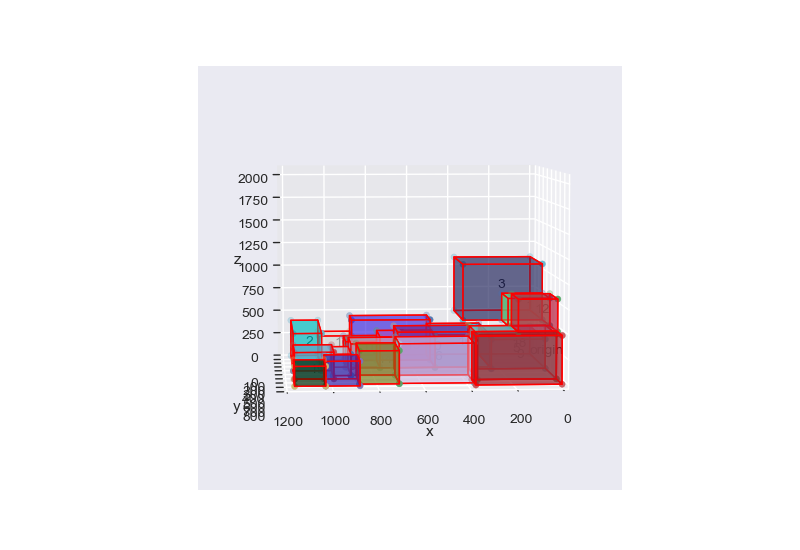

<IPython.core.display.Javascript object>

In [144]:
cg_bin_pool = bins.BinPool(filtered_cg_layer_pool, config.PALLET_DIMS)
cg_bin_pool.plot()

In [ ]:
np.floor(np.mean(cg_bins_lbs) / config.PALLET_HEIGHT)

## Comparison

In [103]:
W, D, _ = config.PALLET_DIMS
print("CG")
print(cg_bin_pool.get_heights())
print(cg_layer_pool.get_densities(W, D, two_dims=False))
print("MR")
print(mr_bin_pool.get_heights())
print(mr_layer_pool.get_densities(W, D, two_dims=False))

CG
[554]
[0.8614552083333333, 0.084775]
MR
[554]
[0.8568260416666666, 0.08940416666666667]


<IPython.core.display.Javascript object>